In [425]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.global_settings as gs
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = gs.FIGURE_DPI
plt.rcParams['savefig.dpi'] = gs.SAVEFIG_DPI

In [426]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [ ]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json'))[0]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'


        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)
        results_df

        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv)
        #runs_df.loc[idx,'best_trial']=analysis.best_trial
        #runs_df.loc[idx,'best_config']=analysis.best_config
        #runs_df.loc[idx,'best_logdir']=analysis.best_logdir
        #runs_df.loc[idx,'best_checkpoint']=analysis.best_checkpoint
        #runs_df.loc[idx,'best_result']=analysis.best_result
    except:
        continue
# TODO: update runs_df+

In [428]:
paths = [row['results_csv'] for idx,row in runs_df.iterrows() if (row['include'] and type (row['results_csv'])==str)]
results_dfs=[pd.read_csv(path) for path in paths]

In [441]:
total_results

,trial_id,date,time_total_s,training_iteration,loss,MARELoss,bsize,dfilter,dnorm,fc_size,hsizes,lr,ltype,source,use_bg,use_power,powers,logdir
0,7d54c_00009,2021-05-07_02-30-01,2296.601451,4.0,41.415855,NaN,32,NaN,False,4,"[3, 3, 3, 3]",0.0005,MAELoss,lidar,False,True,"([0.5,0.5],[0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
1,7d54c_00003,2021-05-06_22-28-03,2599.558585,4.0,31.290869,NaN,32,NaN,False,32,"[3, 3, 3, 3]",0.0010,MAELoss,lidar,False,True,"([0.5,0.5],[0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
2,7d54c_00041,2021-05-08_00-15-13,683.551777,1.0,148.198227,NaN,32,NaN,False,4,"[3, 3, 3, 3]",0.0001,MAELoss,signal,False,True,"([0.5,0.5],[0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
3,7d54c_00025,2021-05-07_13-12-22,2500.368573,4.0,32.670639,NaN,32,NaN,False,4,"[3, 3, 3, 3]",0.0010,MAELoss,signal,False,True,"([0.5,0.5],[0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
4,7d54c_00033,2021-05-07_18-51-57,2372.483233,4.0,46.721329,NaN,32,NaN,False,4,"[3, 3, 3, 3]",0.0005,MAELoss,signal,False,True,"([0.5,0.5],[0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,16f3f_00001,2021-05-18_22-36-12,586.199455,3.0,36.208717,0.216953,32,NaN,False,16,"[3, 3, 3, 3]",0.0010,MAELoss,lidar,True,True,"([0.5,0.25, 1], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
486,16f3f_00014,2021-05-19_01-00-52,590.824120,4.0,24.941408,0.156627,32,NaN,True,32,"[3, 3, 3, 3]",0.0010,MAELoss,lidar,True,True,"([0.5,0.5, 1], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
487,16f3f_00000,2021-05-18_22-17-00,223.511365,1.0,149.067719,1.000000,32,NaN,True,16,"[3, 3, 3, 3]",0.0010,MAELoss,lidar,True,True,"([0.5,0.25, 1], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...
488,16f3f_00007,2021-05-18_23-48-41,494.322919,3.0,19.392616,0.120540,32,NaN,False,32,"[4, 4, 4, 4]",0.0010,MAELoss,lidar,True,True,"([0.5,0.25, 1], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...


In [ ]:
total_results = pd.concat(results_dfs,ignore_index=True)
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
lidar_res = total_results[total_results.source=='lidar' ]
lidar_res = lidar_res[~lidar_res.use_bg]

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

<ipython-input-430-d26c5d65d894>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pow_lidar['powers'] = pow_lidar.powers.apply(lambda x: eval(str(x)))


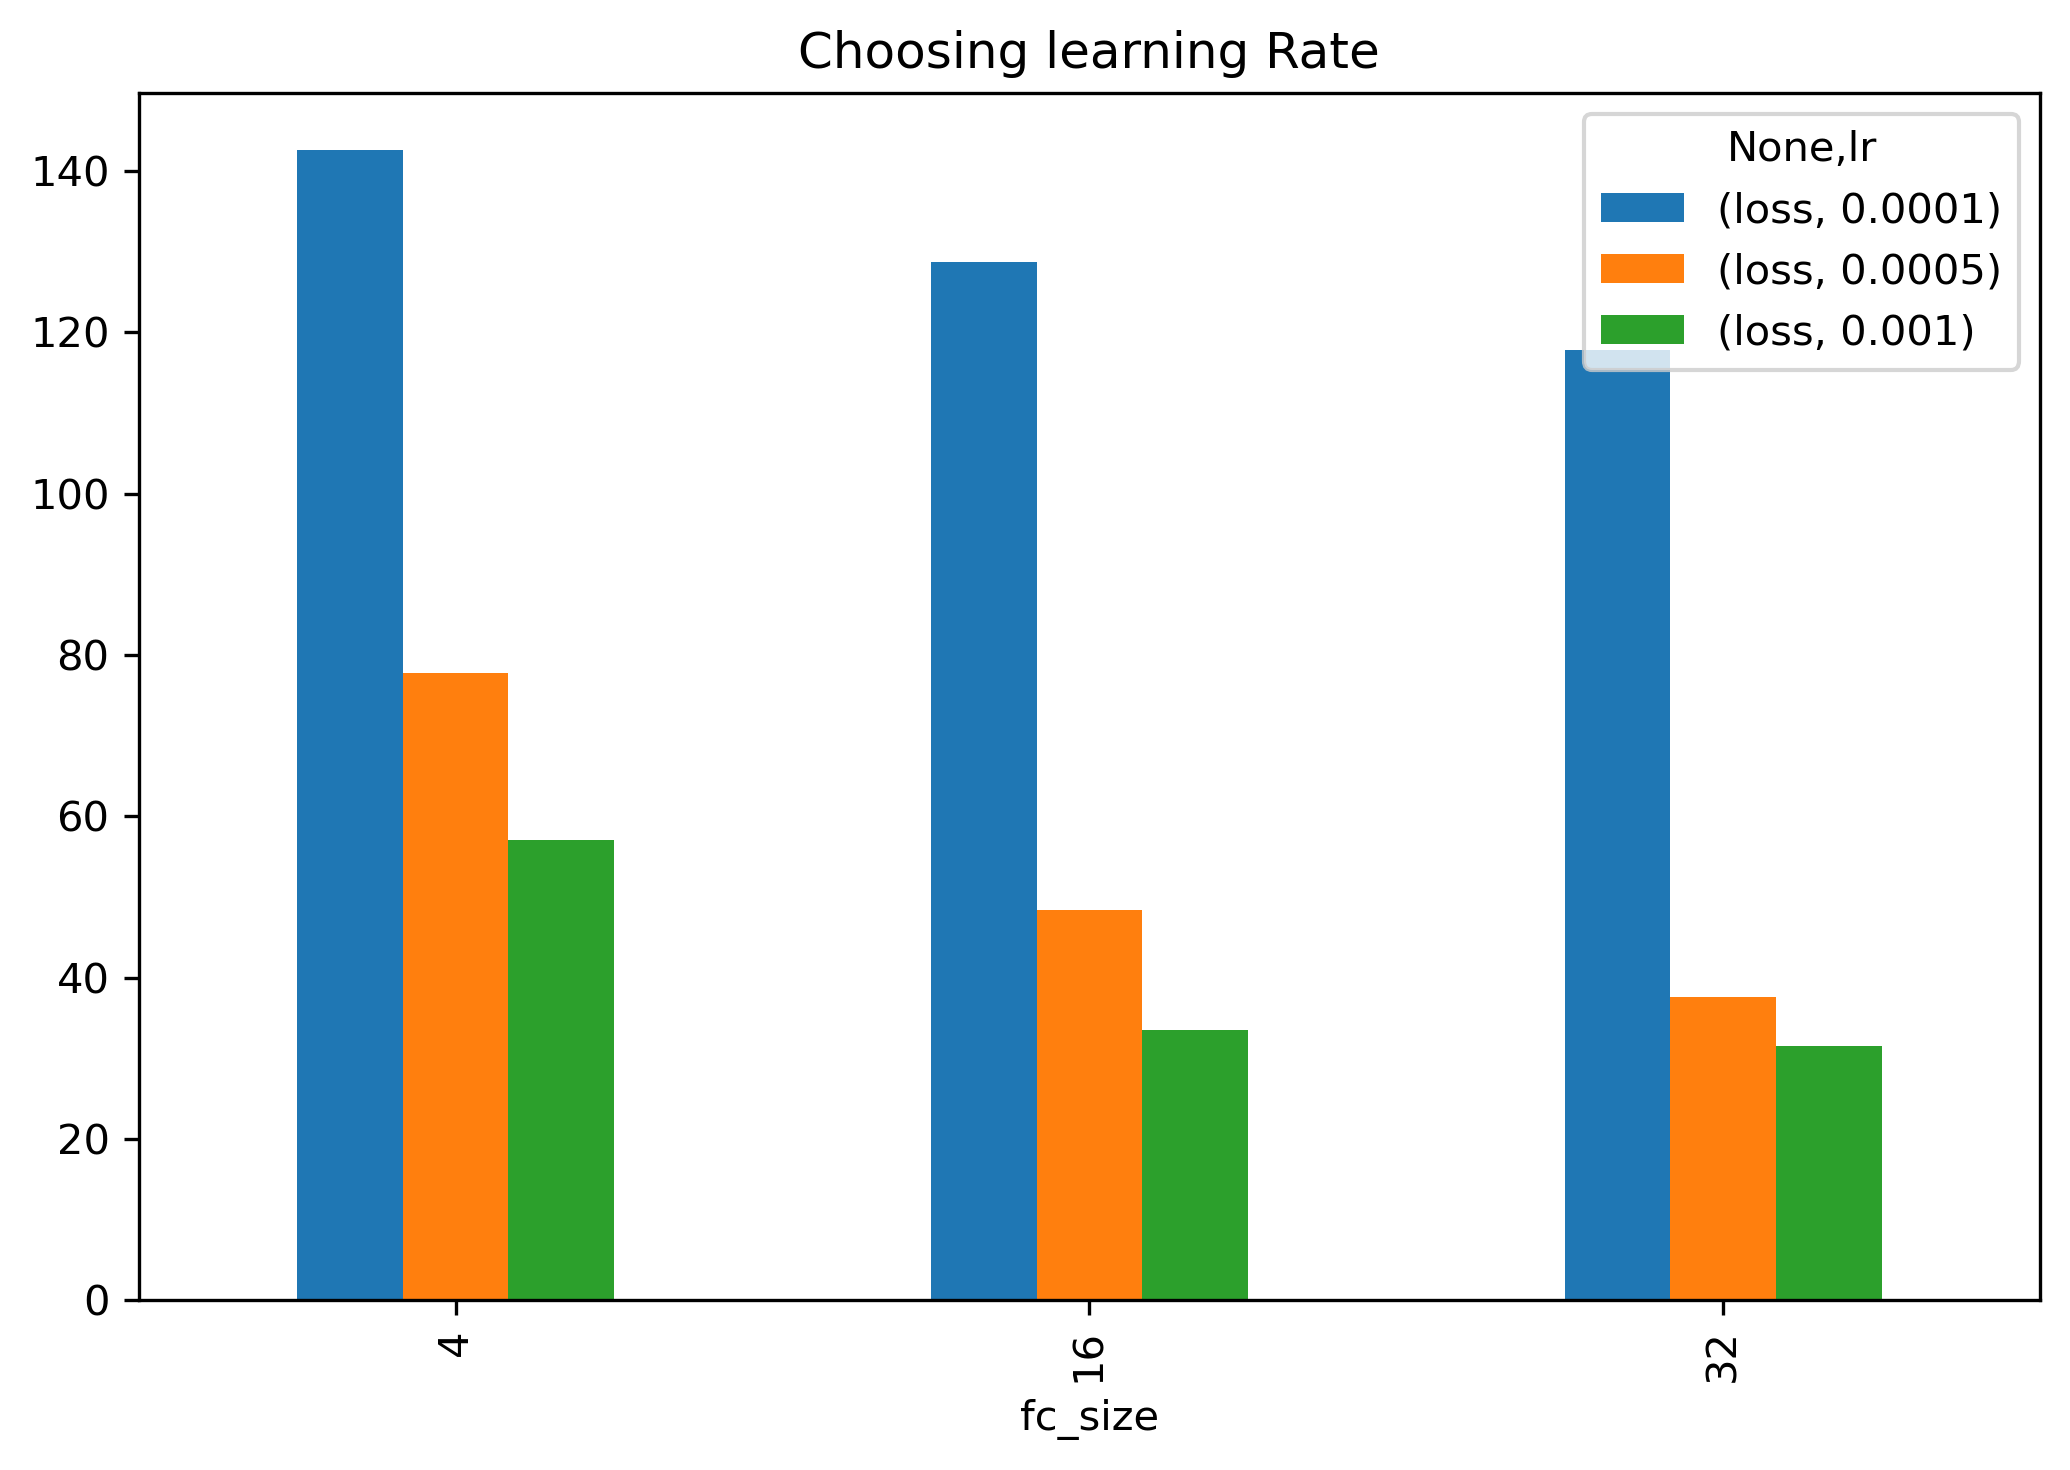

In [430]:
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]
pow_lidar['powers'] = pow_lidar.powers.apply(lambda x: eval(str(x)))
pow_lidar = pow_lidar[pow_lidar.powers==([0.5,0.5],[0.5])]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar,
               values=['loss'],
               columns= ['lr'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

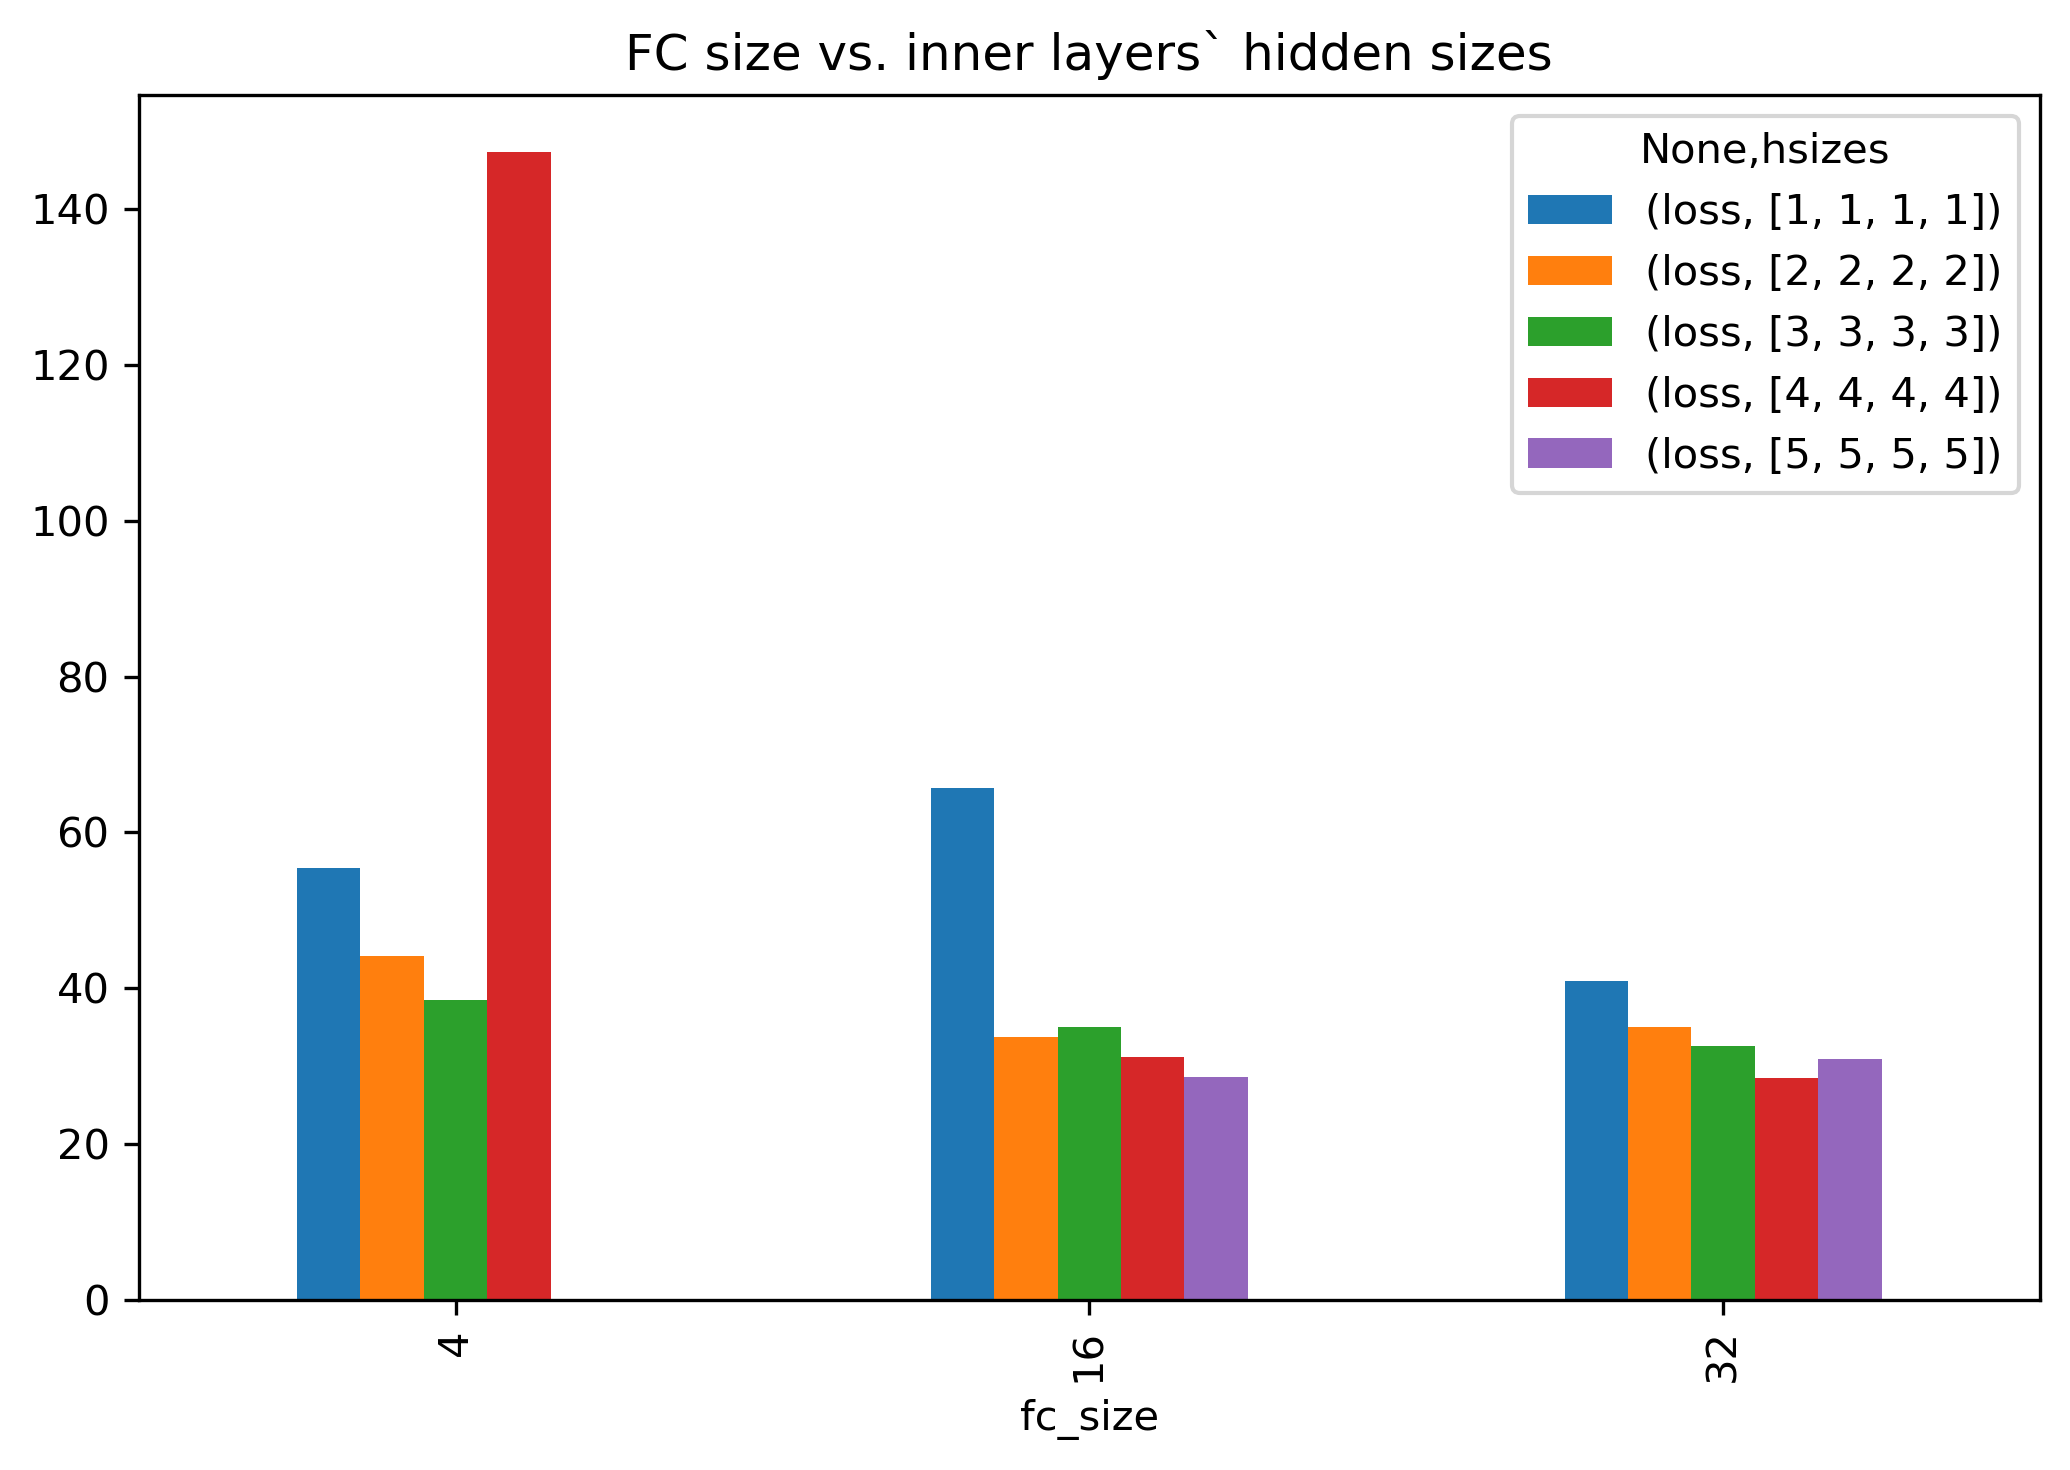

In [431]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(pow_lidar[pow_lidar.lr!=0.0001],
               values=['loss'],
               columns= ['hsizes'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='FC size vs. inner layers` hidden sizes')
plt.tight_layout()
plt.show()

## 3. Normalization vs. Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = False
> source = lidar

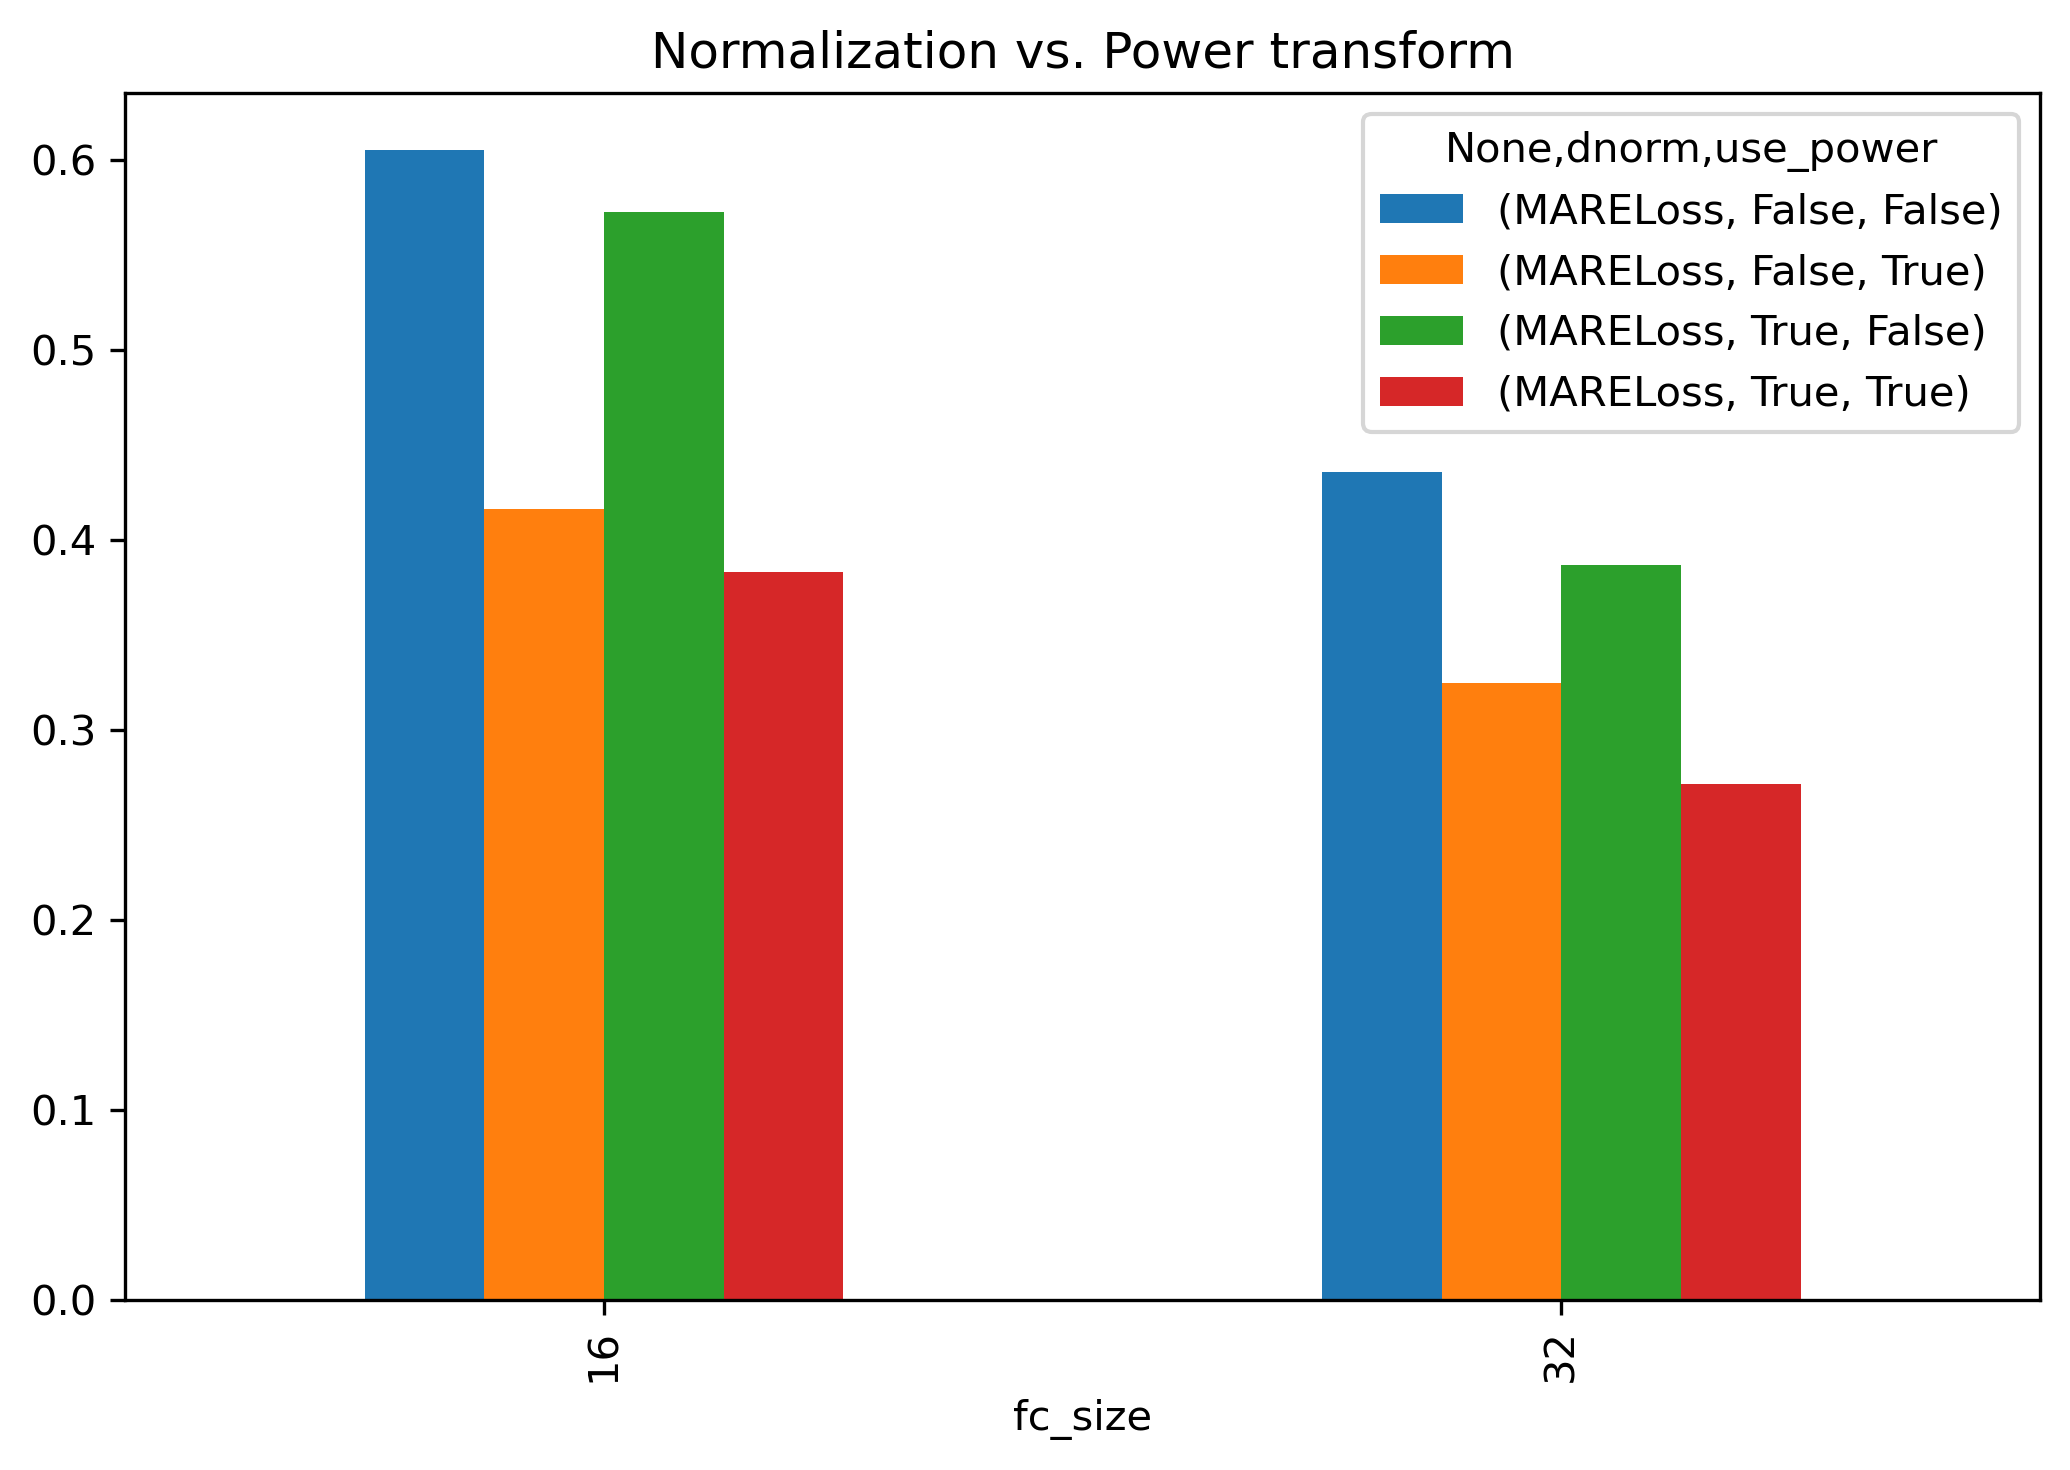

In [432]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(lidar_res,
               values=['MARELoss'],
               columns= ['dnorm','use_power'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Normalization vs. Power transform')
plt.tight_layout()
plt.show()

## 3. Type of Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> source = lidar
> use_bg = False
> dnorm = False
> lr = 0.001

In [479]:
pow_lidar = total_results[total_results.source=='lidar']
pow_lidar= pow_lidar[pow_lidar.use_power & ~pow_lidar.dnorm & ~total_results.use_bg]
pow_lidar = pow_lidar[pow_lidar.lr==0.001]
pow_lidar['powers'] = pow_lidar.powers.apply(lambda x: eval(str(x)))

pow_lidar['pow_y'] = pow_lidar.powers.apply(lambda x: np.array(x[1])[0])
pow_lidar['pow_x'] = pow_lidar.powers.apply(lambda x: np.array(x[0]))
pow_lidar['pow_x1'] = [powx[0] for powx in pow_lidar['pow_x']]
pow_lidar['pow_x2'] = [powx[1] for powx in pow_lidar['pow_x']]
pow_lidar['pow_x'] = pow_lidar.pow_x.apply(lambda x: (str(x[0]),str(x[1])))
pow_lidar['pow_y'] = pow_lidar.pow_y.apply(lambda x: str(x))


<ipython-input-479-3b531bfde327>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pow_lidar= pow_lidar[pow_lidar.use_power & ~pow_lidar.dnorm & ~total_results.use_bg]


,trial_id,date,time_total_s,training_iteration,loss,MARELoss,bsize,dfilter,dnorm,fc_size,...,ltype,source,use_bg,use_power,powers,logdir,pow_y,pow_x,pow_x1,pow_x2
1,7d54c_00003,2021-05-06_22-28-03,2599.558585,4.0,31.290869,NaN,32,NaN,False,32,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
15,7d54c_00005,2021-05-06_23-40-03,1864.109313,3.0,39.916477,NaN,32,NaN,False,4,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
20,7d54c_00001,2021-05-06_20-59-31,2547.437453,4.0,39.278648,NaN,32,NaN,False,4,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
23,7d54c_00007,2021-05-07_00-51-33,1240.332803,2.0,34.083263,NaN,32,NaN,False,32,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
30,fdf9a_00003,2021-05-08_23-11-20,4445.028469,3.0,35.344681,NaN,32,NaN,False,16,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
31,fdf9a_00001,2021-05-08_19-59-13,4349.824512,3.0,33.484505,NaN,32,NaN,False,16,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
44,76b01_00009,2021-05-10_06-02-25,2038.164855,3.0,30.255188,NaN,32,NaN,False,16,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
48,76b01_00003,2021-05-10_01-44-16,2586.774298,4.0,43.924606,NaN,32,NaN,False,16,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
49,76b01_00007,2021-05-10_04-09-57,708.624934,1.0,147.654221,NaN,32,NaN,False,4,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50
53,76b01_00011,2021-05-10_07-44-55,2720.530125,4.0,26.309042,NaN,32,NaN,False,32,...,MAELoss,lidar,False,True,"([0.5, 0.5], [0.5])",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,"(0.5, 0.5)",0.5,0.50


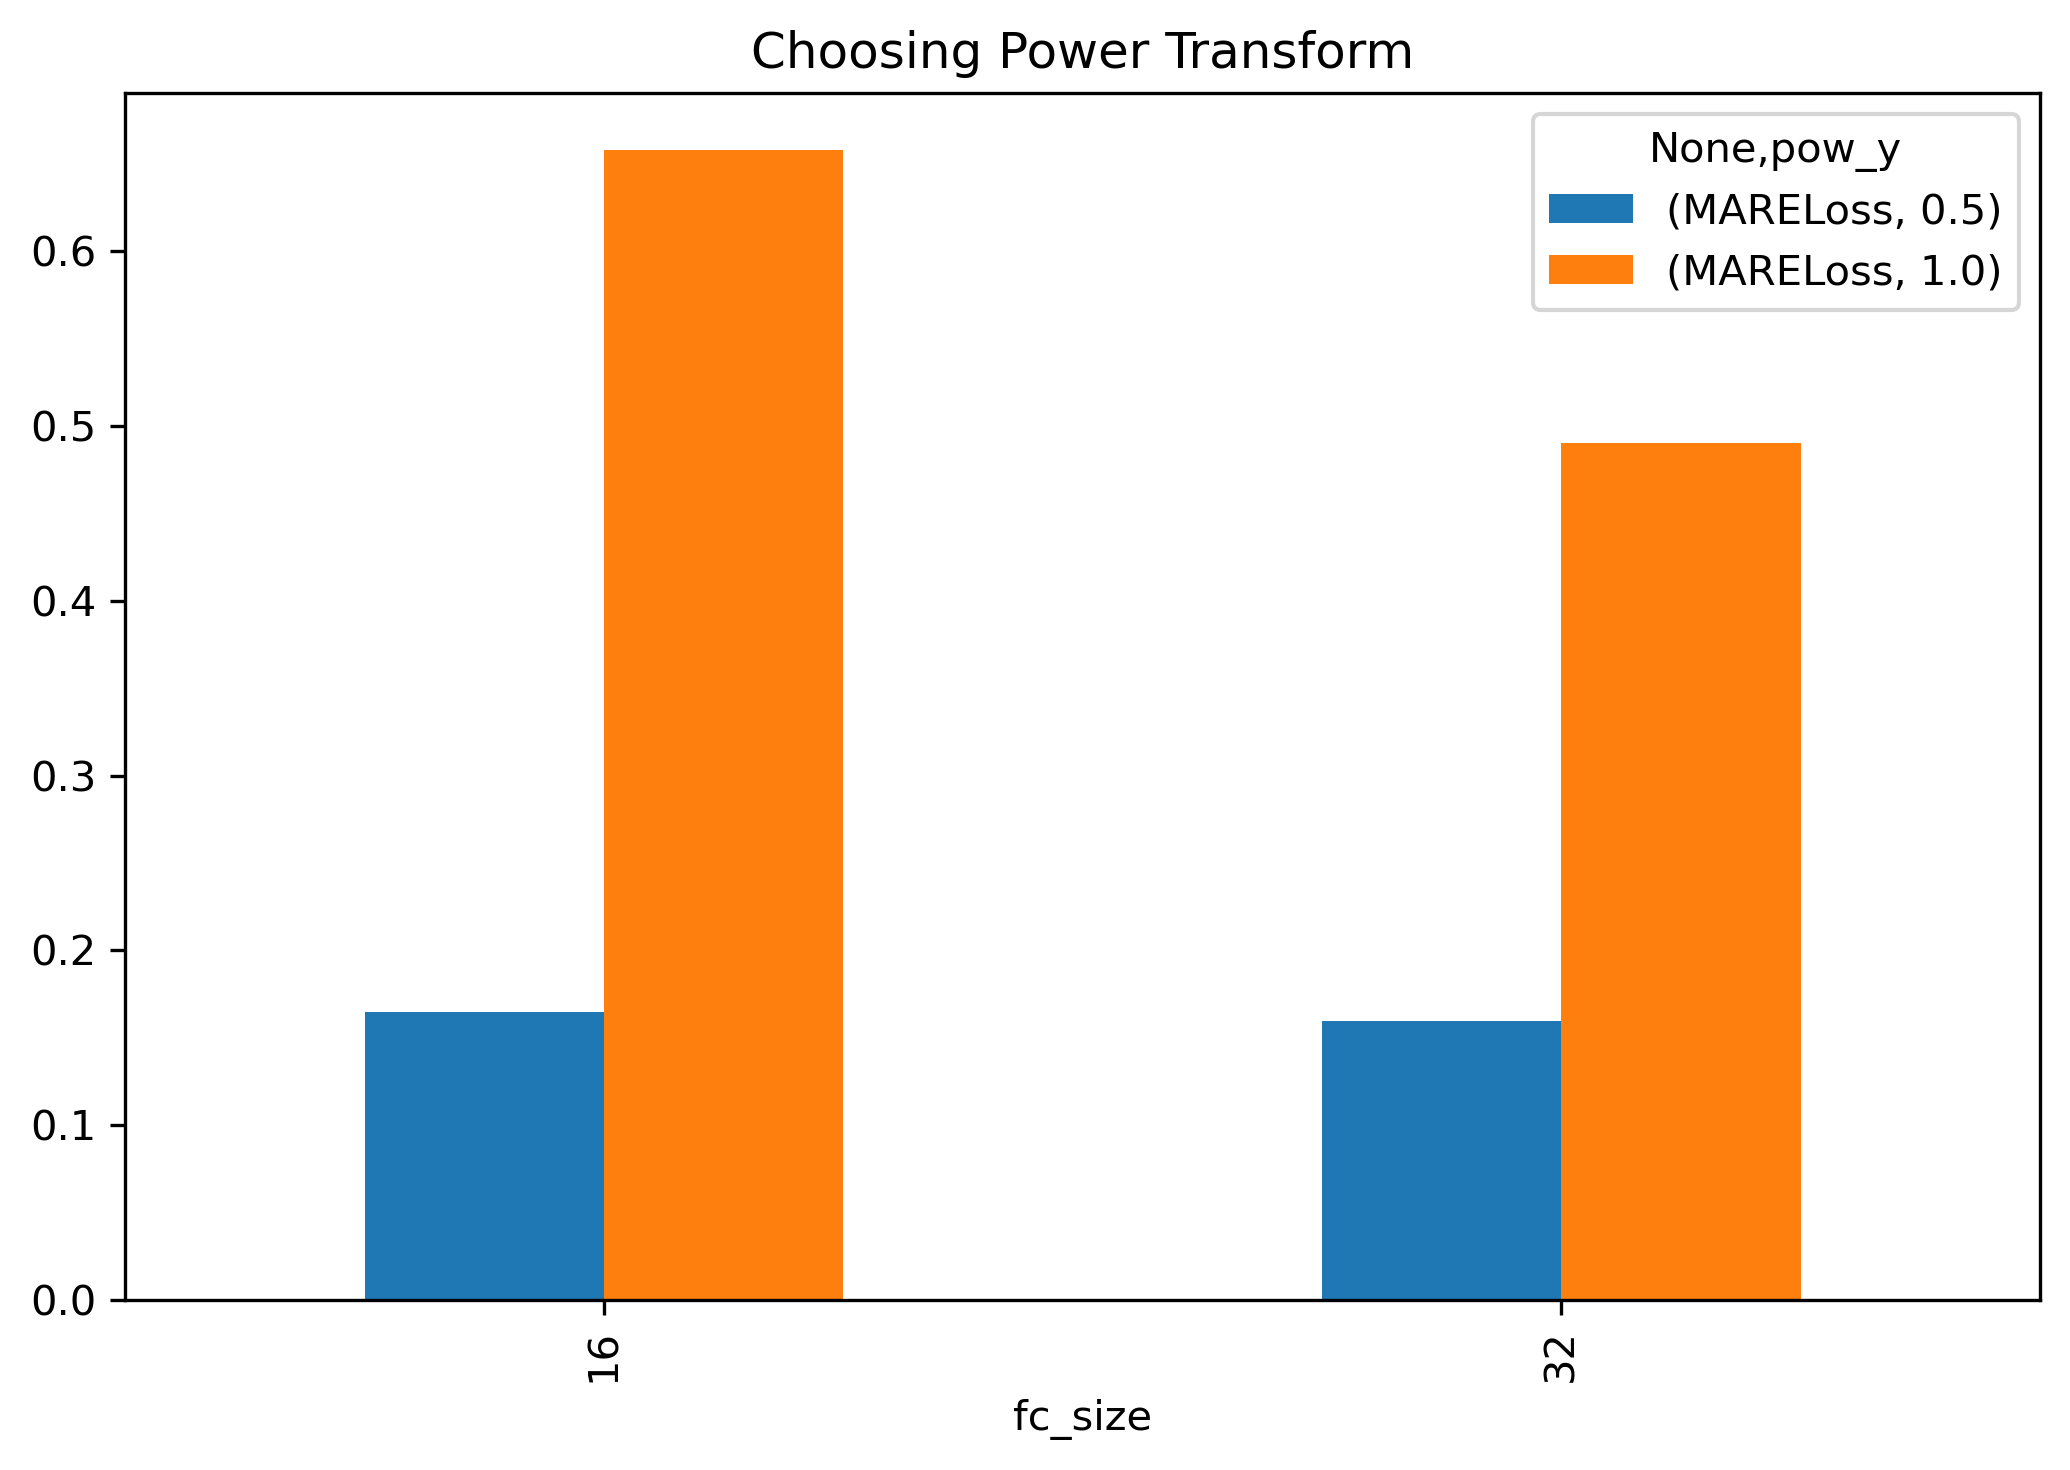

In [434]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar,
               values=['MARELoss'],
               columns= ['pow_y' ],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform')
plt.tight_layout()
plt.show()

<ipython-input-553-e64e5d91b821>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[pow_lidar['pow_y']=='0.5'][(pow_lidar['pow_x1']==0.5)],


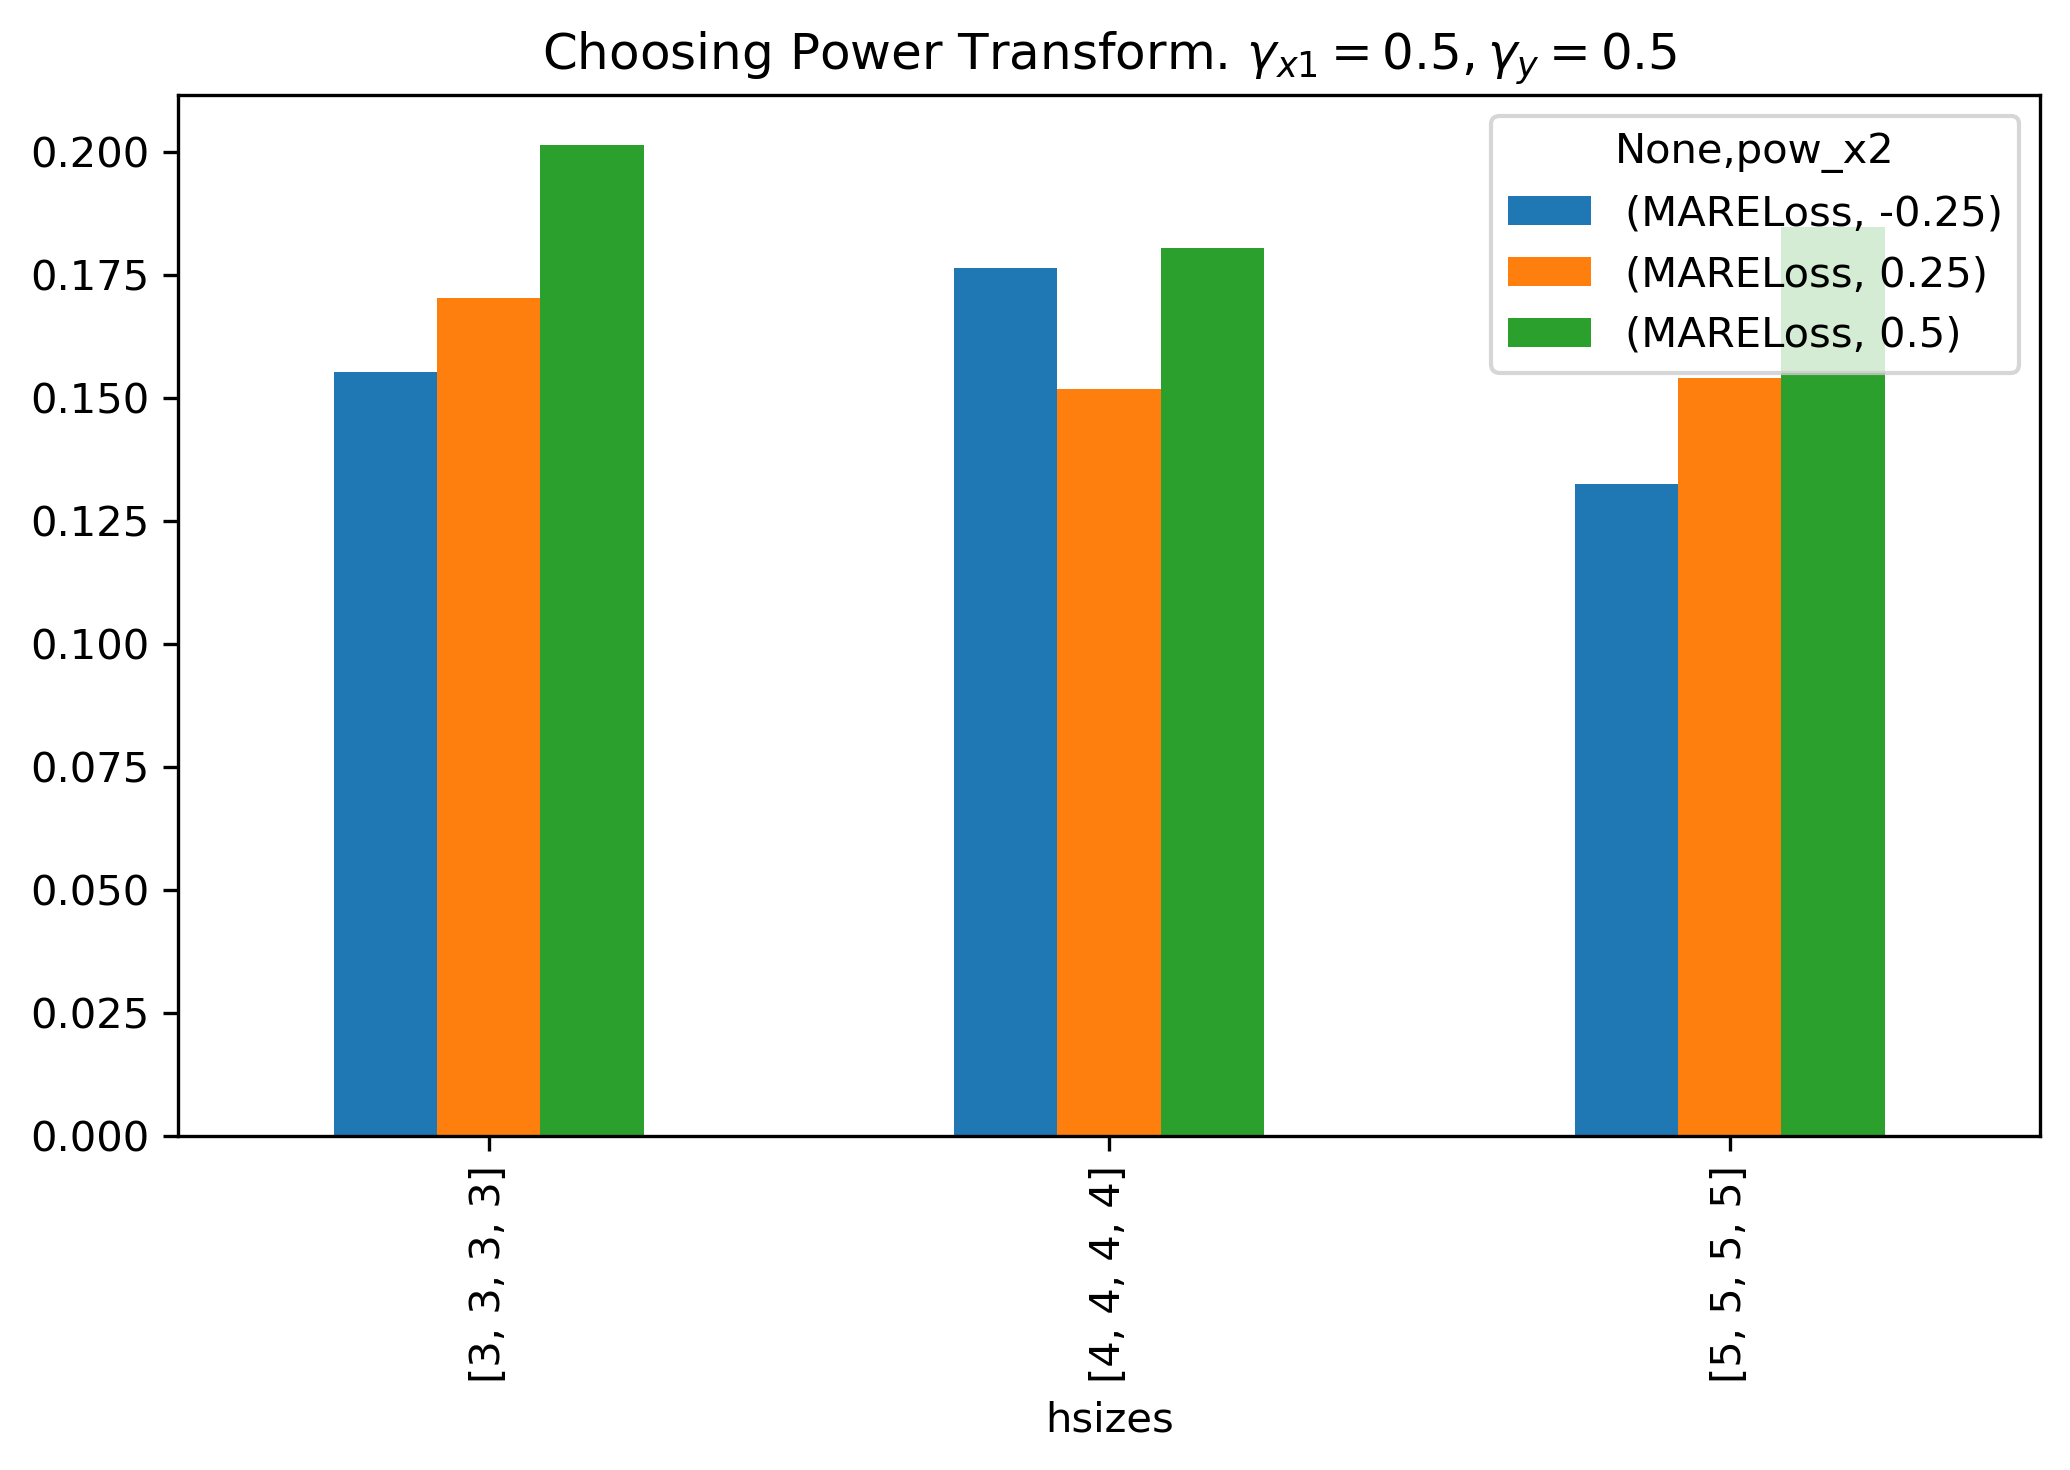

In [553]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar['pow_y']=='0.5'][(pow_lidar['pow_x1']==0.5)],
               values=['MARELoss'],
               columns= ['pow_x2'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
plt.tight_layout()
plt.show()

<ipython-input-554-67141bd1128c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[(pow_lidar['pow_y']=='0.5')][(pow_lidar['pow_x1']==0.5)],


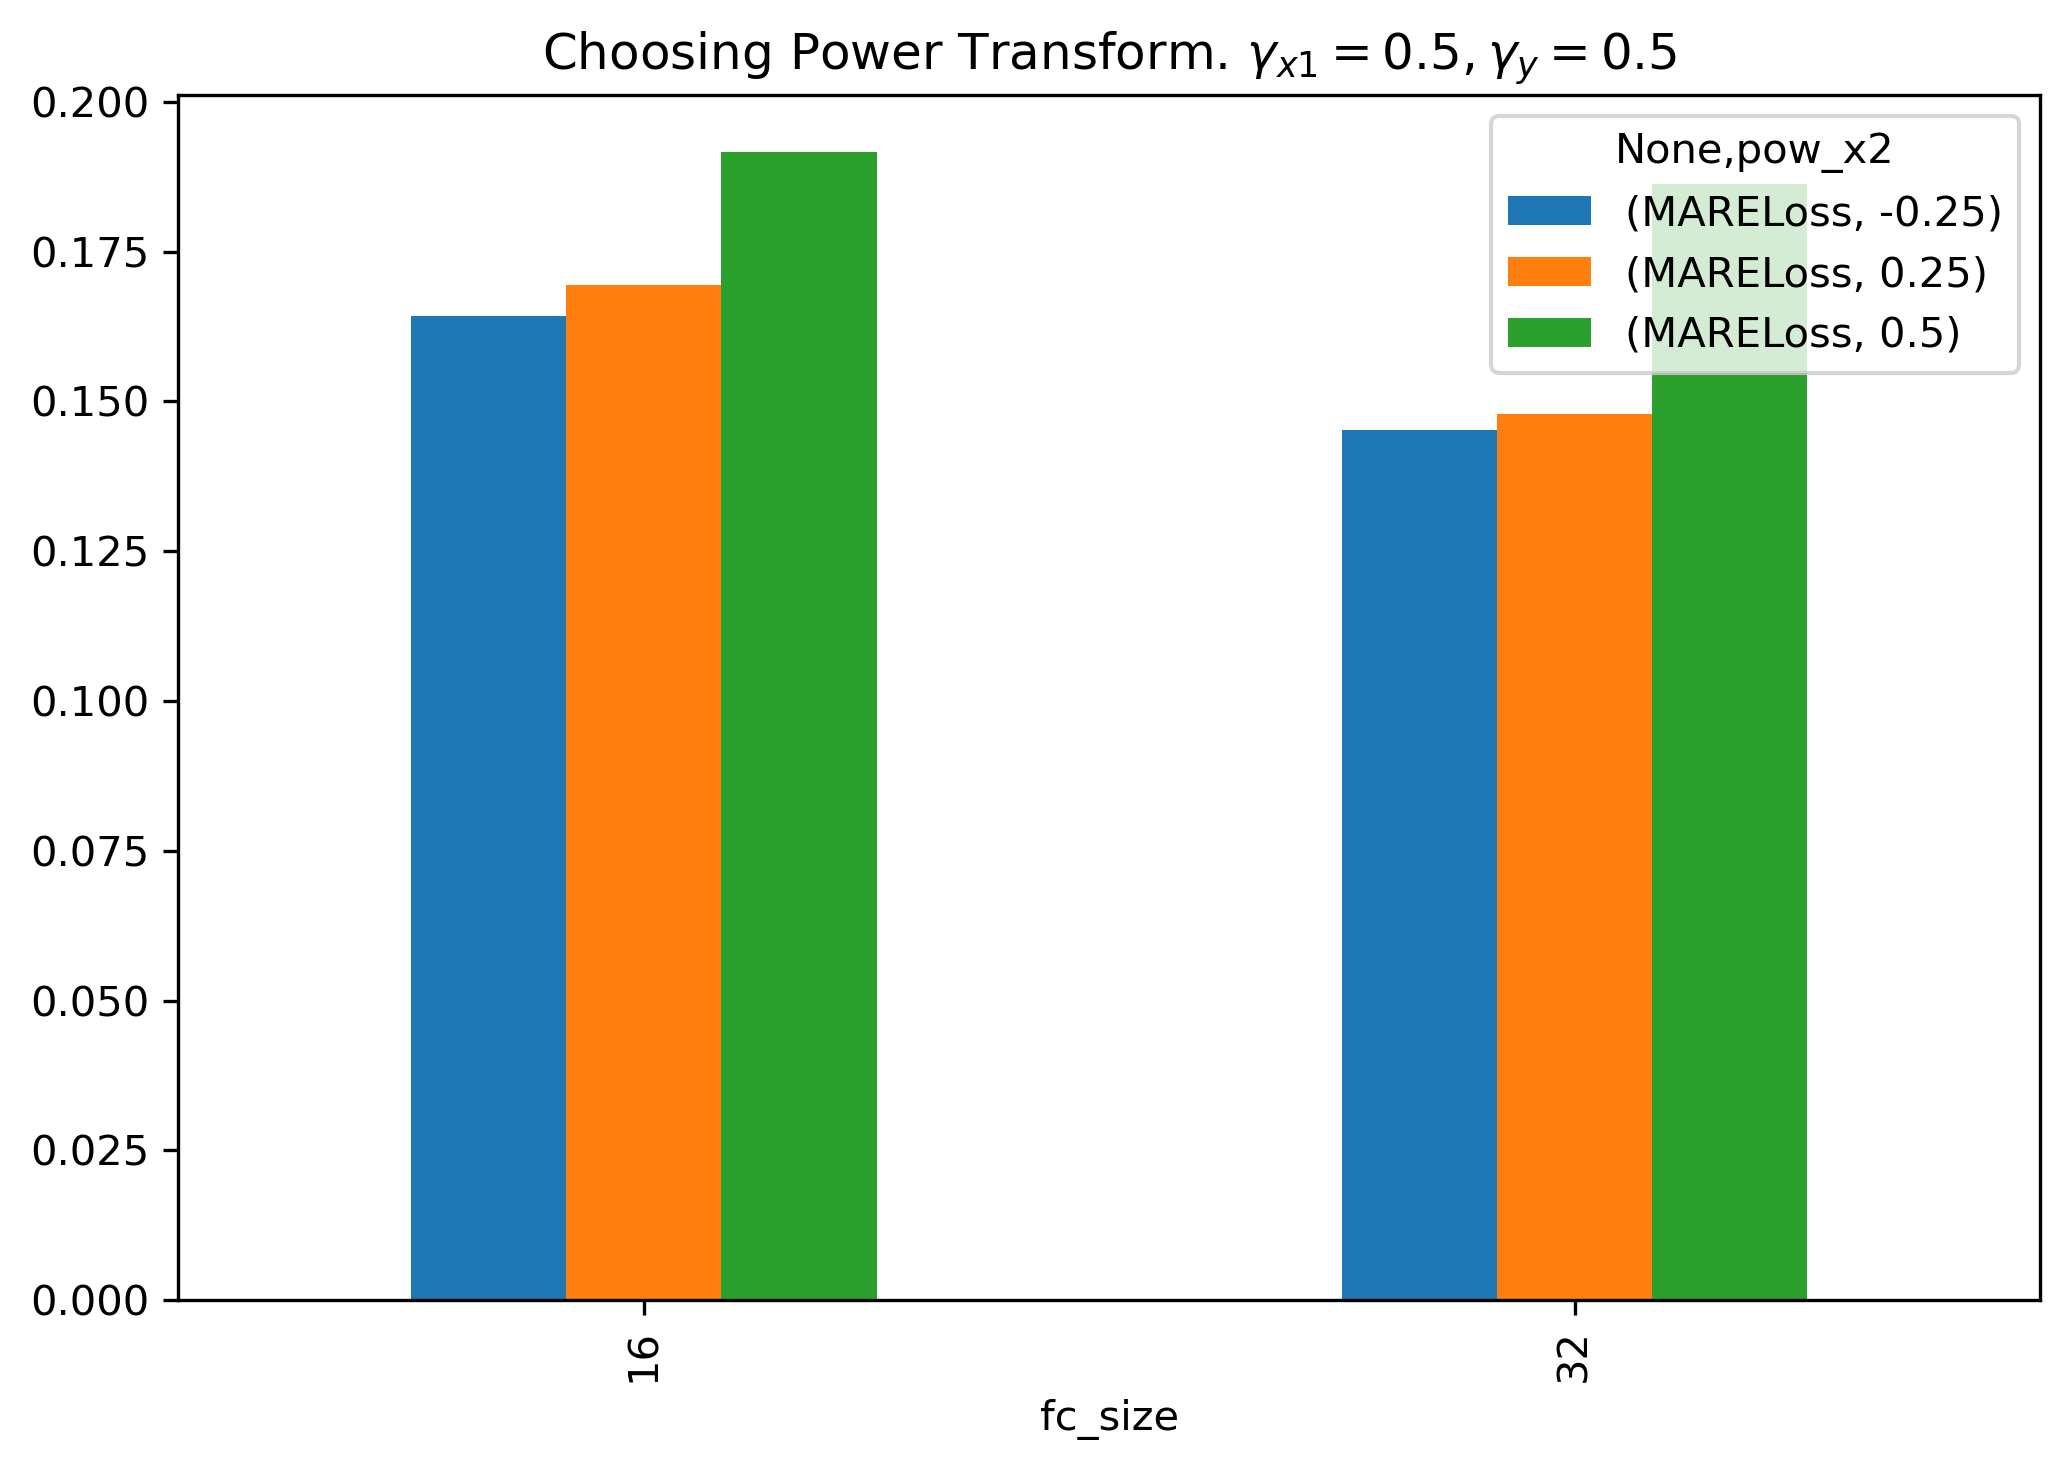

In [554]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[(pow_lidar['pow_y']=='0.5')][(pow_lidar['pow_x1']==0.5)],
               values=['MARELoss'],
               columns= ['pow_x2'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
plt.tight_layout()
plt.show()

## 3. Type of source
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> use_bg = False
> source = all
> dnorm = True
> lr > 0.0001

<ipython-input-562-f001a7e7f230>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sources_res = sources_res[total_results.lr==0.001]
<ipython-input-562-f001a7e7f230>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sources_res = sources_res[total_results.fc_size>4]


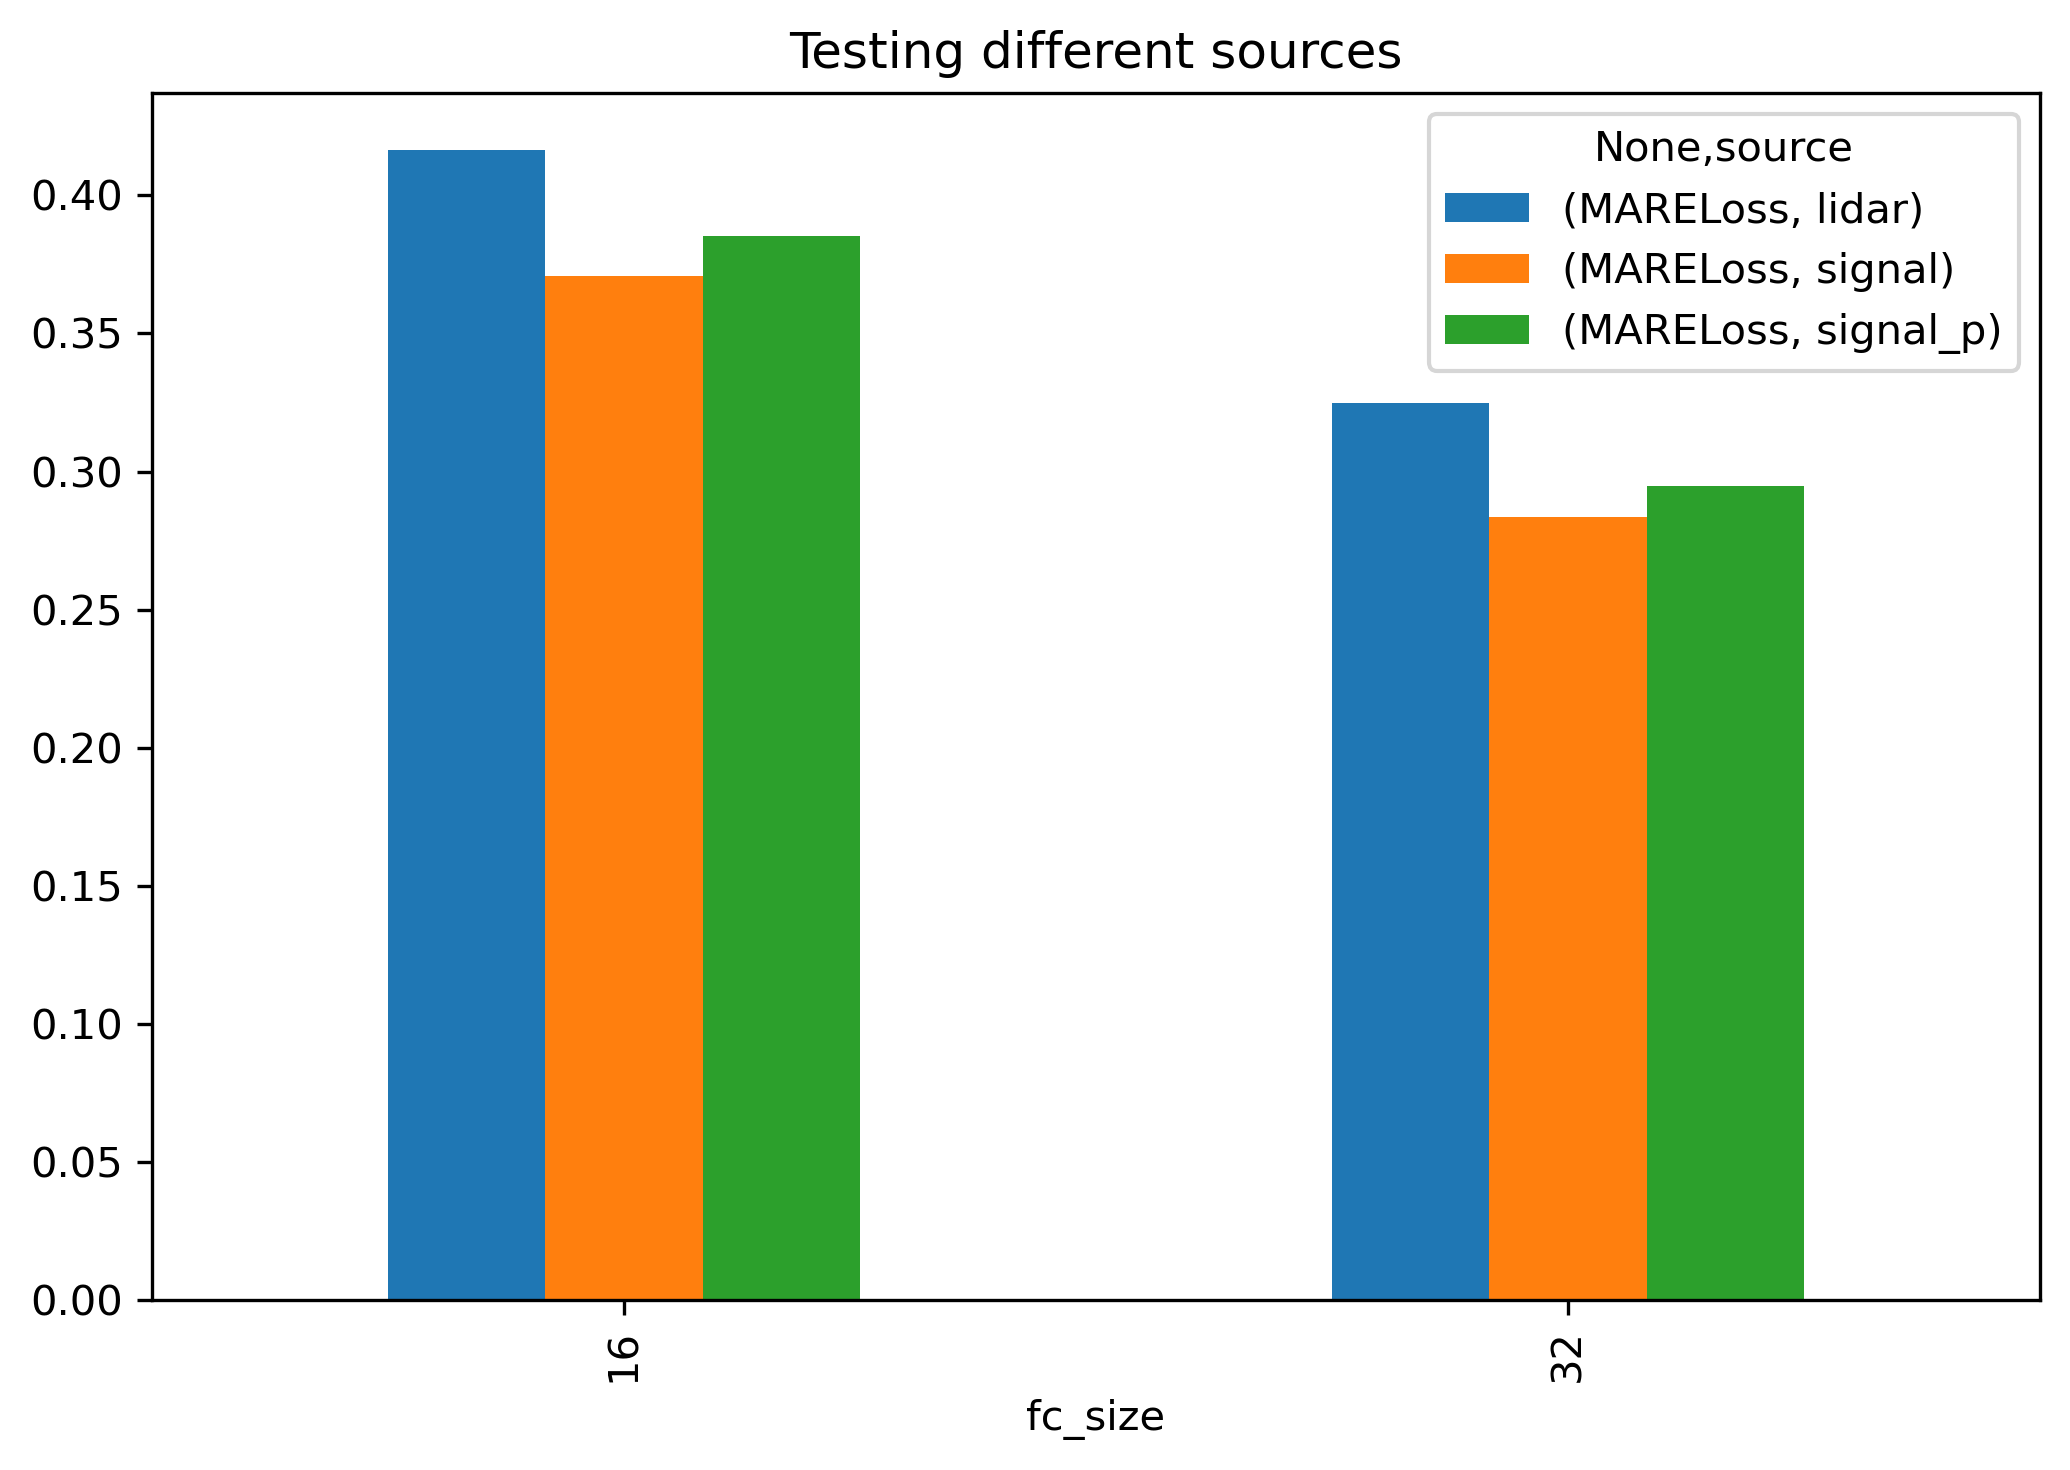

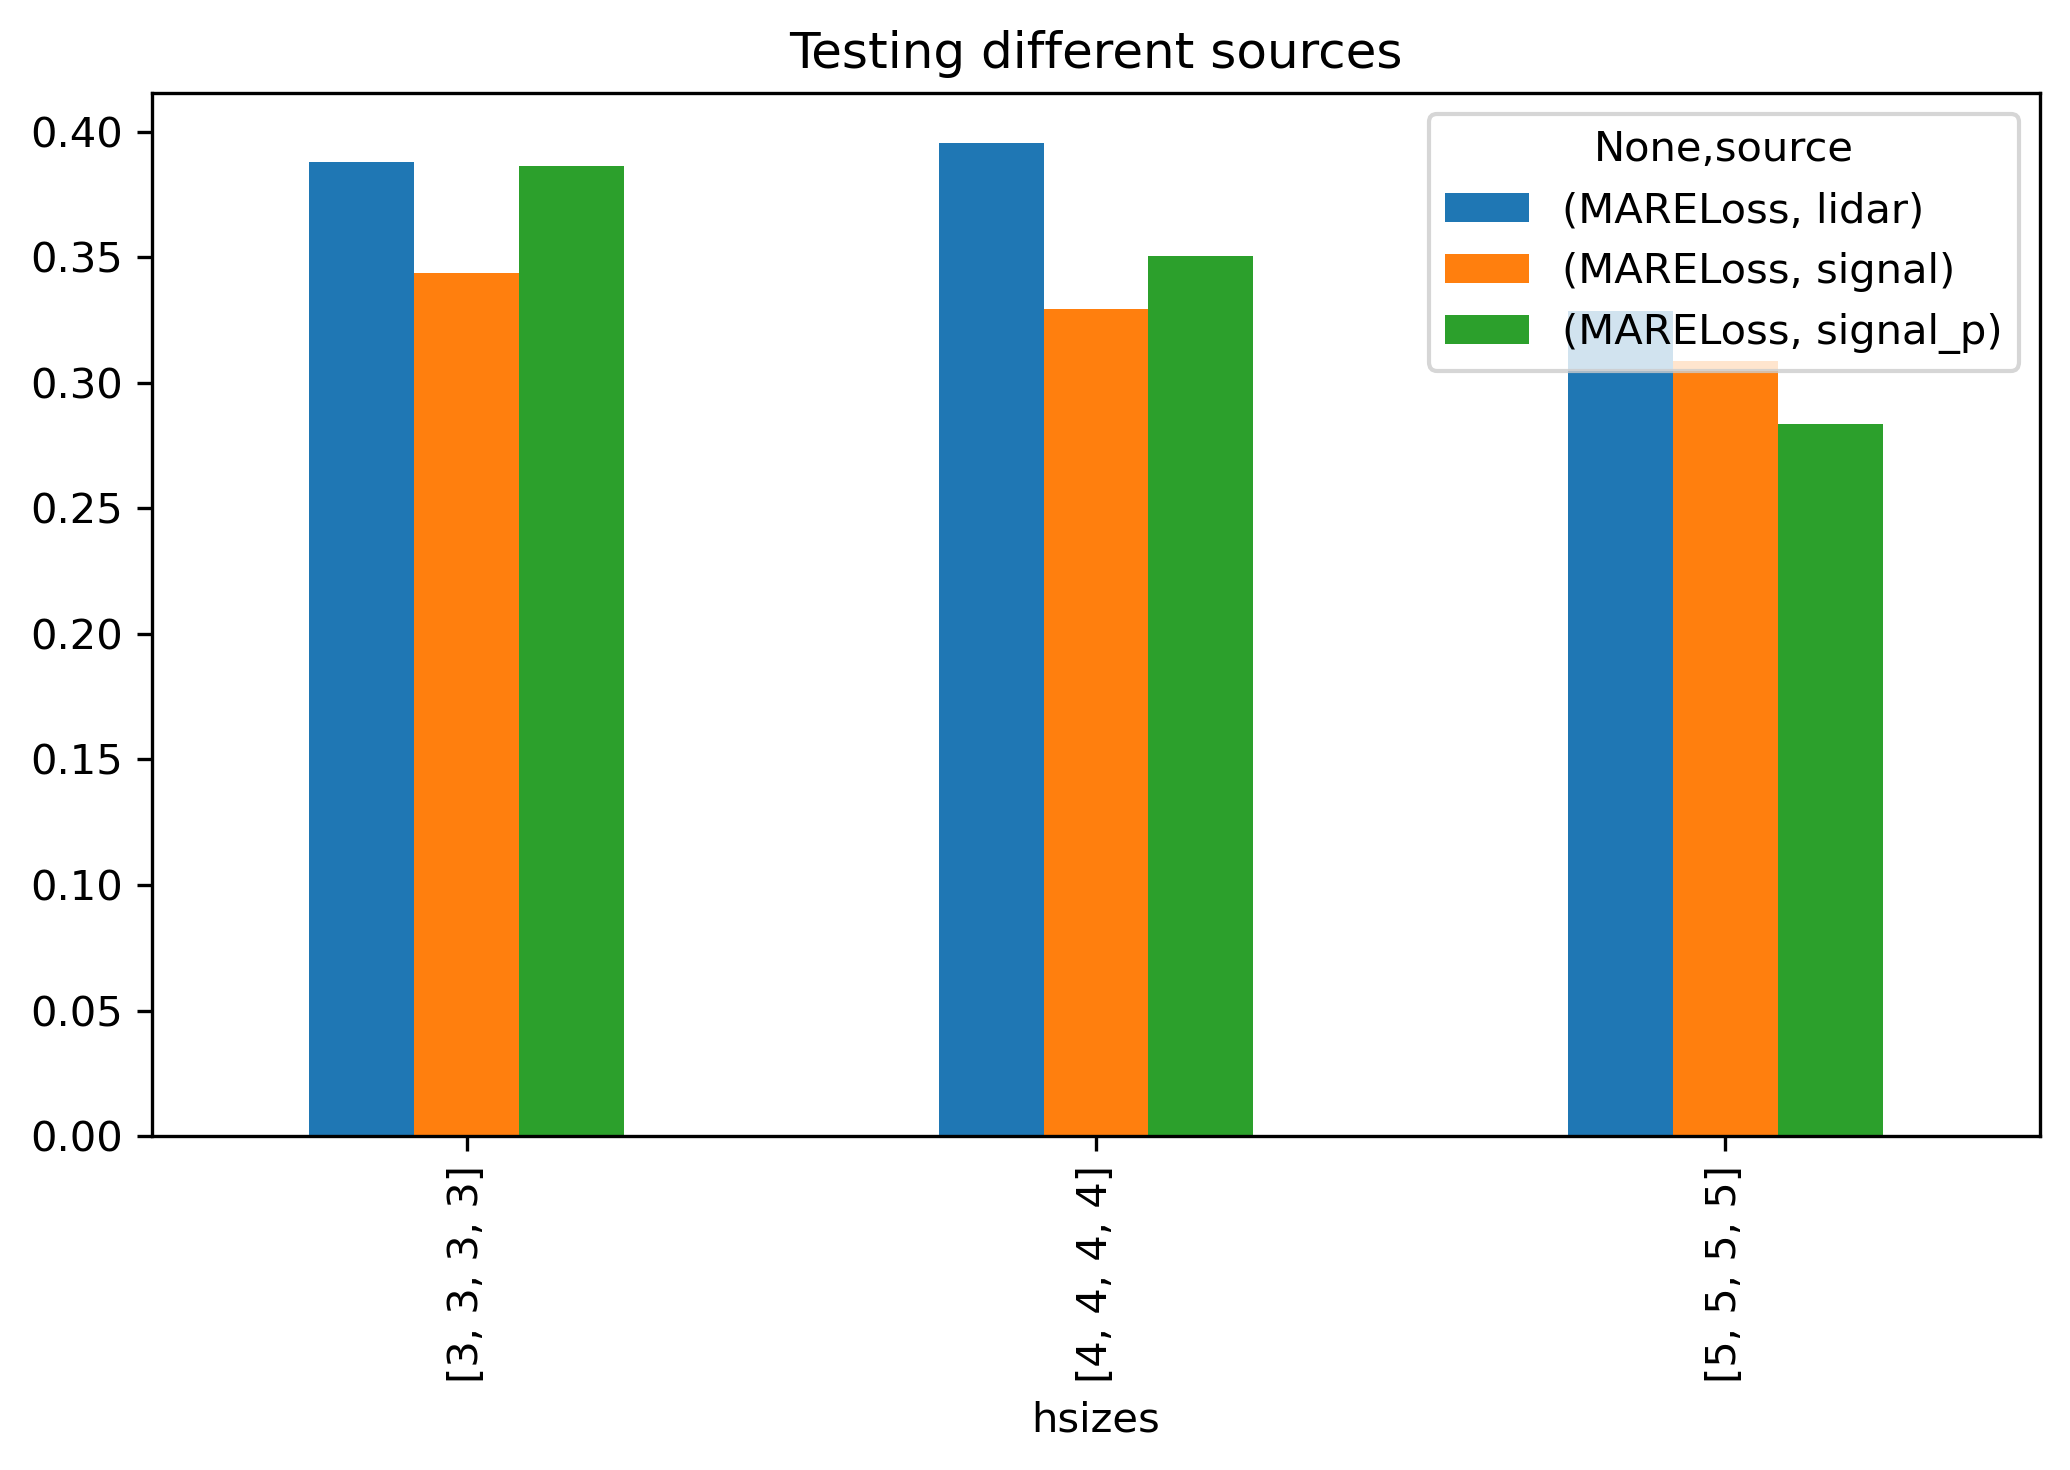

In [562]:
sources_res = total_results[(total_results.use_power &
                             ~total_results.dnorm &
                             ~total_results.use_bg)]
sources_res = sources_res[total_results.lr==0.001]
sources_res = sources_res[total_results.fc_size>4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,
               values=['MARELoss'],
               columns= ['source'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Testing different sources')
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,
               values=['MARELoss'],
               columns= ['source'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Testing different sources')
plt.tight_layout()
plt.show()

## 3. Adding
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> fc_size>4
> source = lidar
> dnorm = False
> lr==0.001
> pow_y = 0.5

In [561]:
bg_res = total_results[total_results.source=='lidar']
bg_res = bg_res[bg_res.use_power &
                ~bg_res.dnorm ]
bg_res = bg_res[bg_res.lr==0.001]
bg_res = bg_res[bg_res.fc_size>4]


bg_res['powers'] = bg_res.powers.apply(lambda x: eval(str(x)))
bg_res['pow_y'] = bg_res.powers.apply(lambda x: np.array(x[1])[0])
bg_res['pow_x'] = bg_res.powers.apply(lambda x: np.array(x[0]))
bg_res = bg_res[bg_res['pow_y']==0.5]

bg_res['pow_x1'] = [powx[0] for powx in bg_res['pow_x']]
bg_res['pow_x2'] = [powx[1] for powx in bg_res['pow_x']]
bg_res['pow_x3'] =[powx[2] if len(powx)==3 else None for powx in bg_res['pow_x']]



bg_res['pow_x'] = bg_res.pow_x.apply(lambda x: str(x))
bg_res['pow_y'] = bg_res.pow_y.apply(lambda x: str(x))

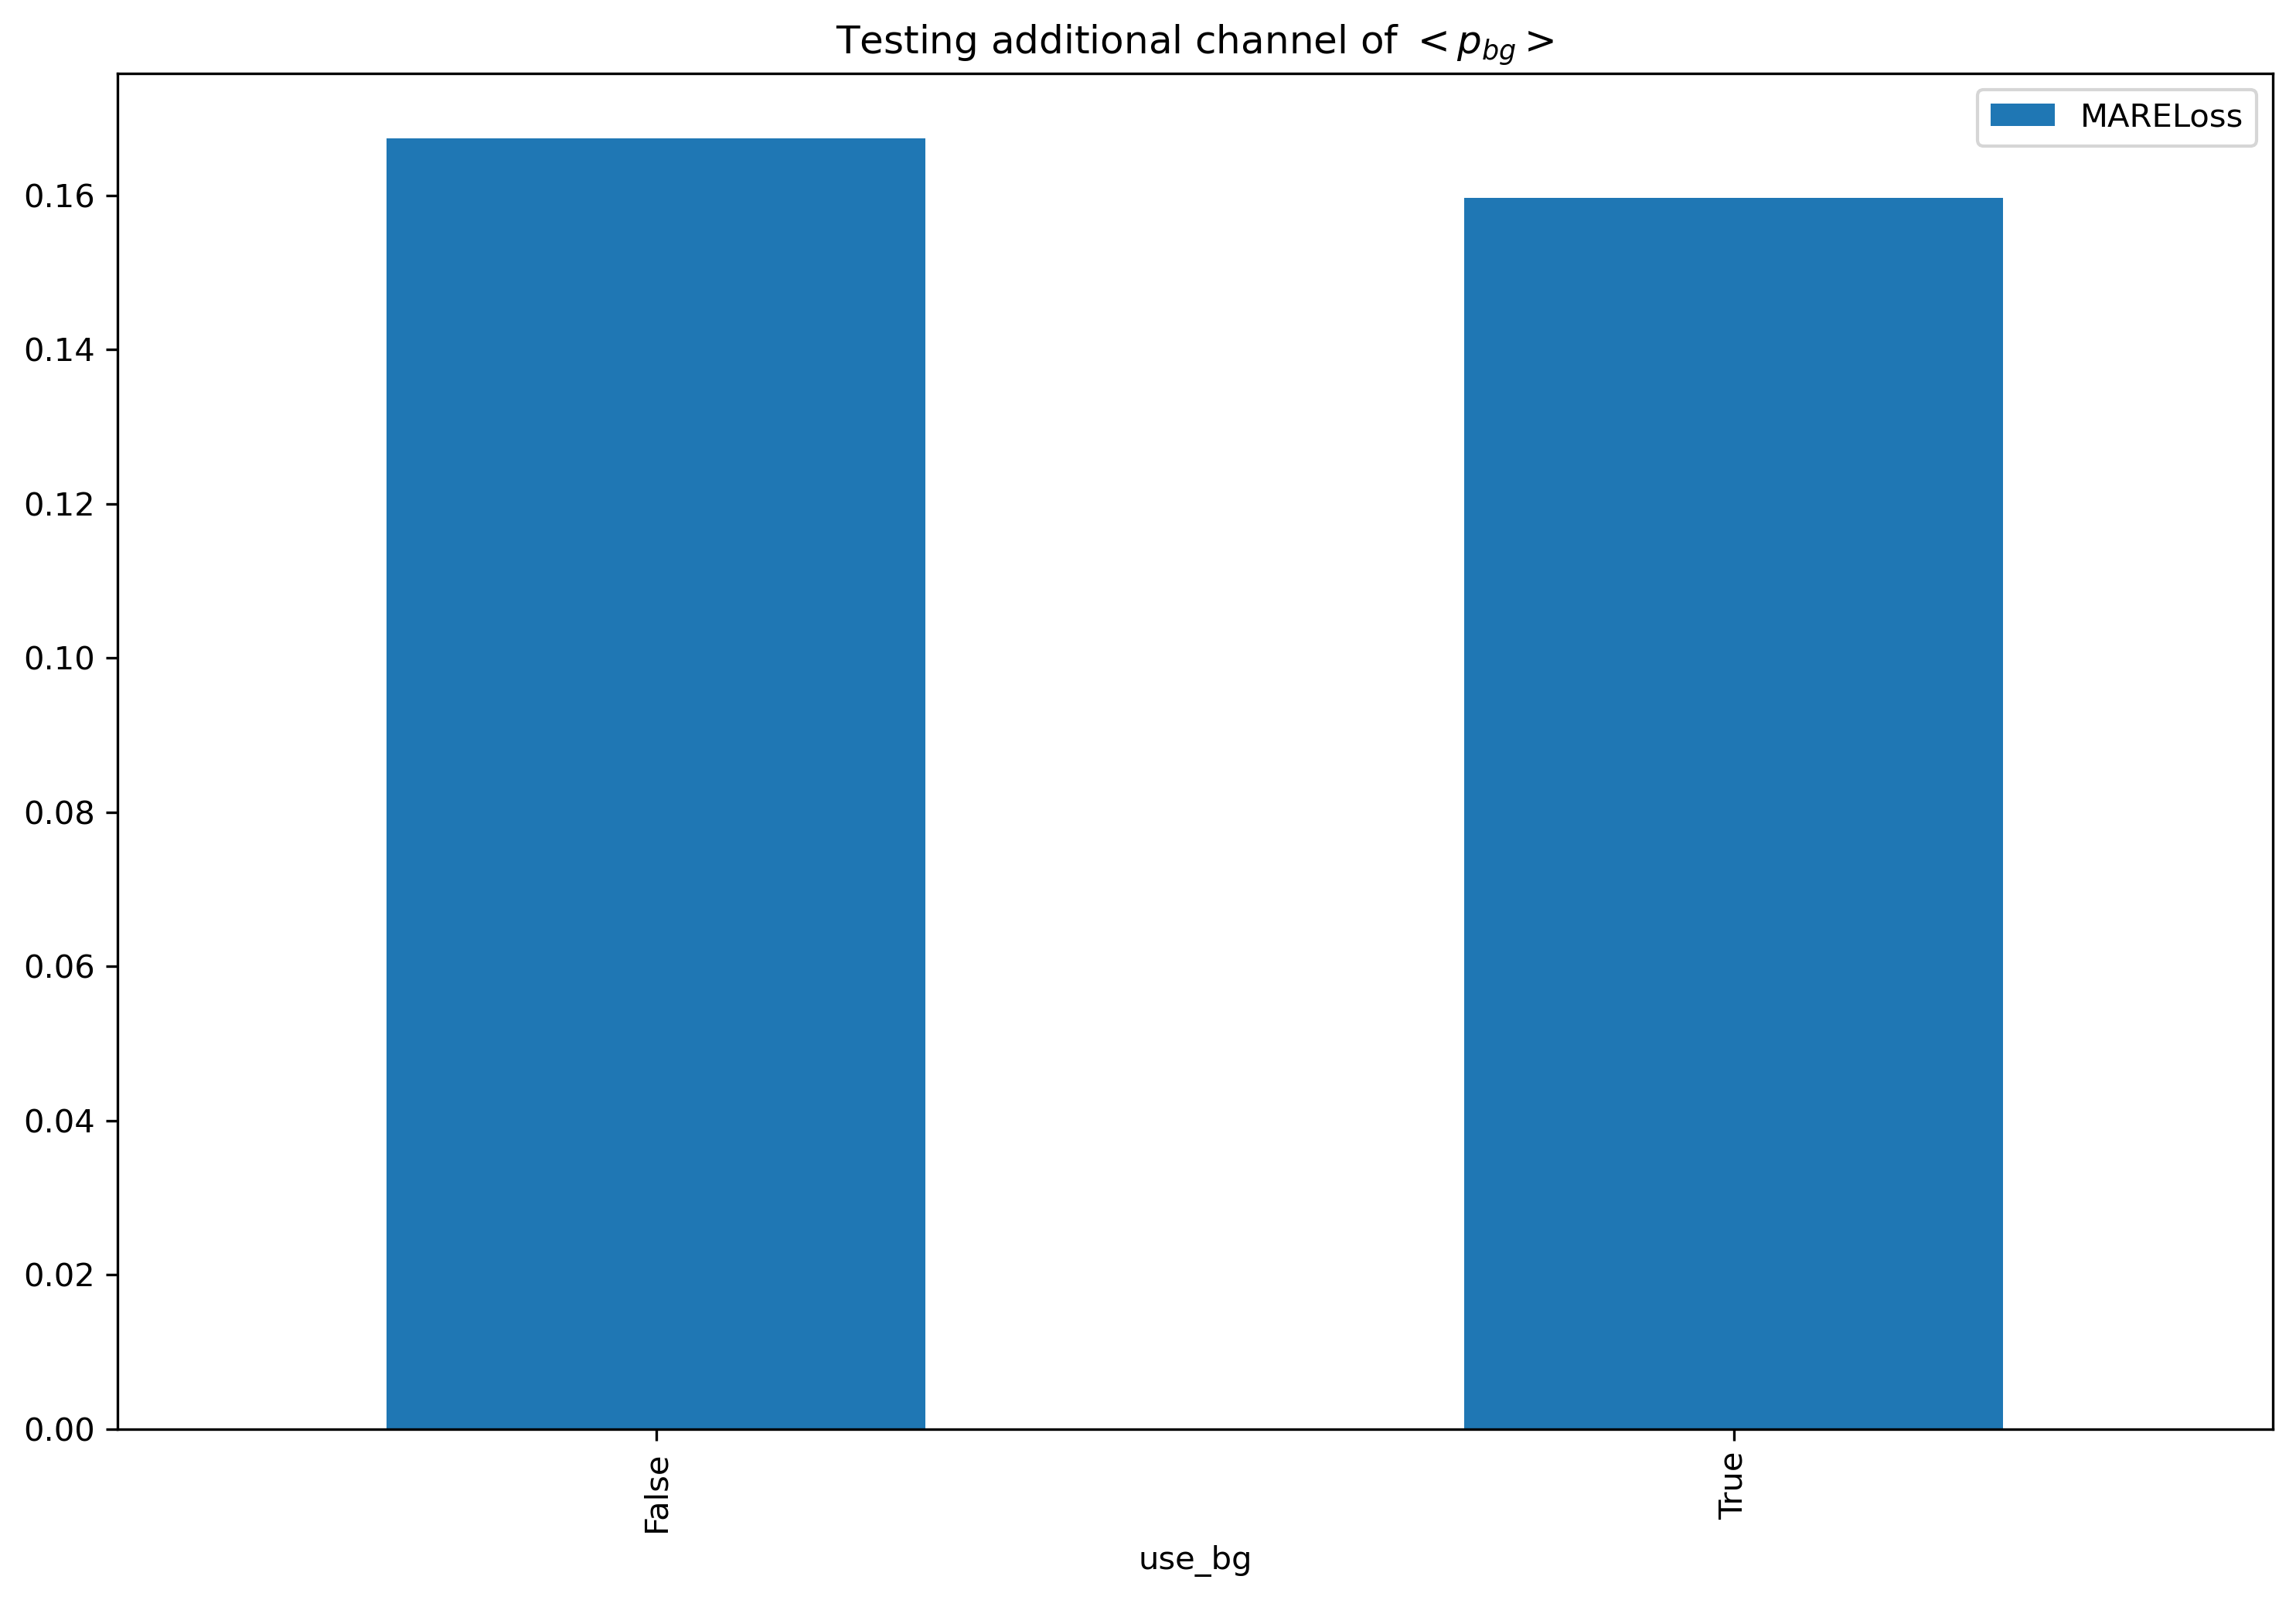

In [568]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res,
               values=['MARELoss'],
               #columns= ['pow_x2'],#'pow_x'],
               index=['use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
plt.tight_layout()
plt.show()

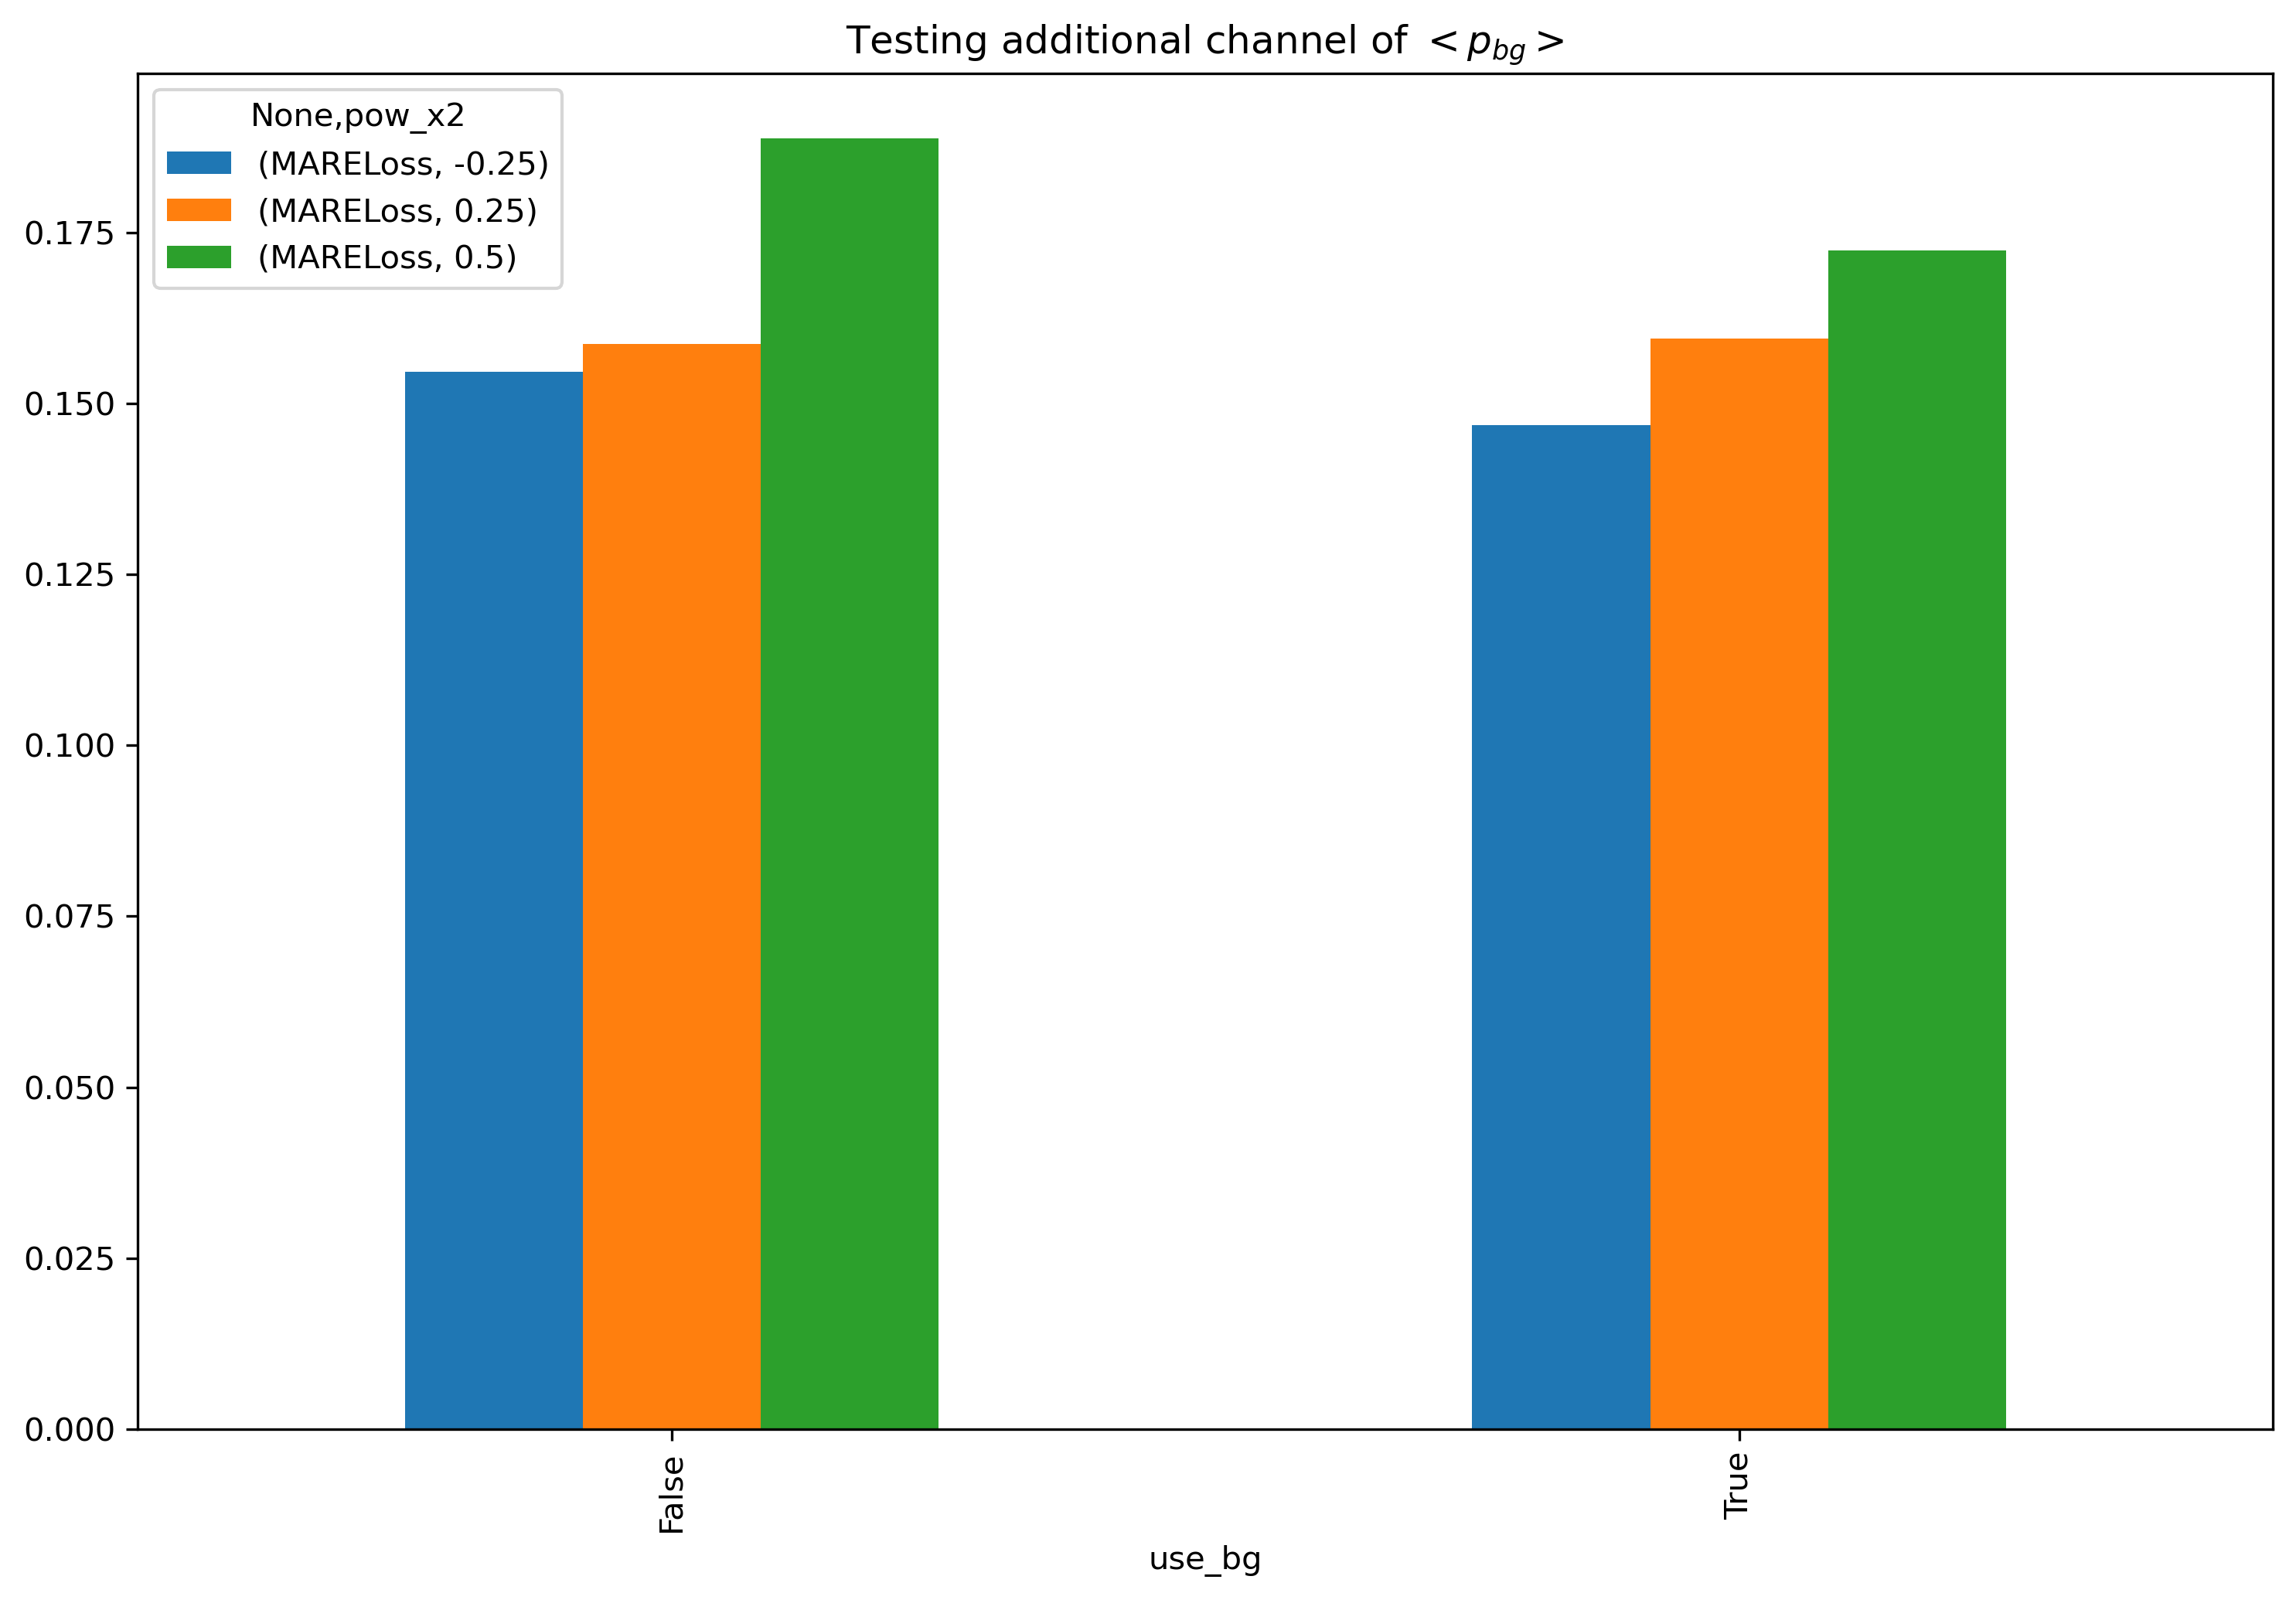

In [572]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res,
               values=['MARELoss'],
               columns= ['pow_x2'],
               index=['use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
plt.tight_layout()
plt.show()

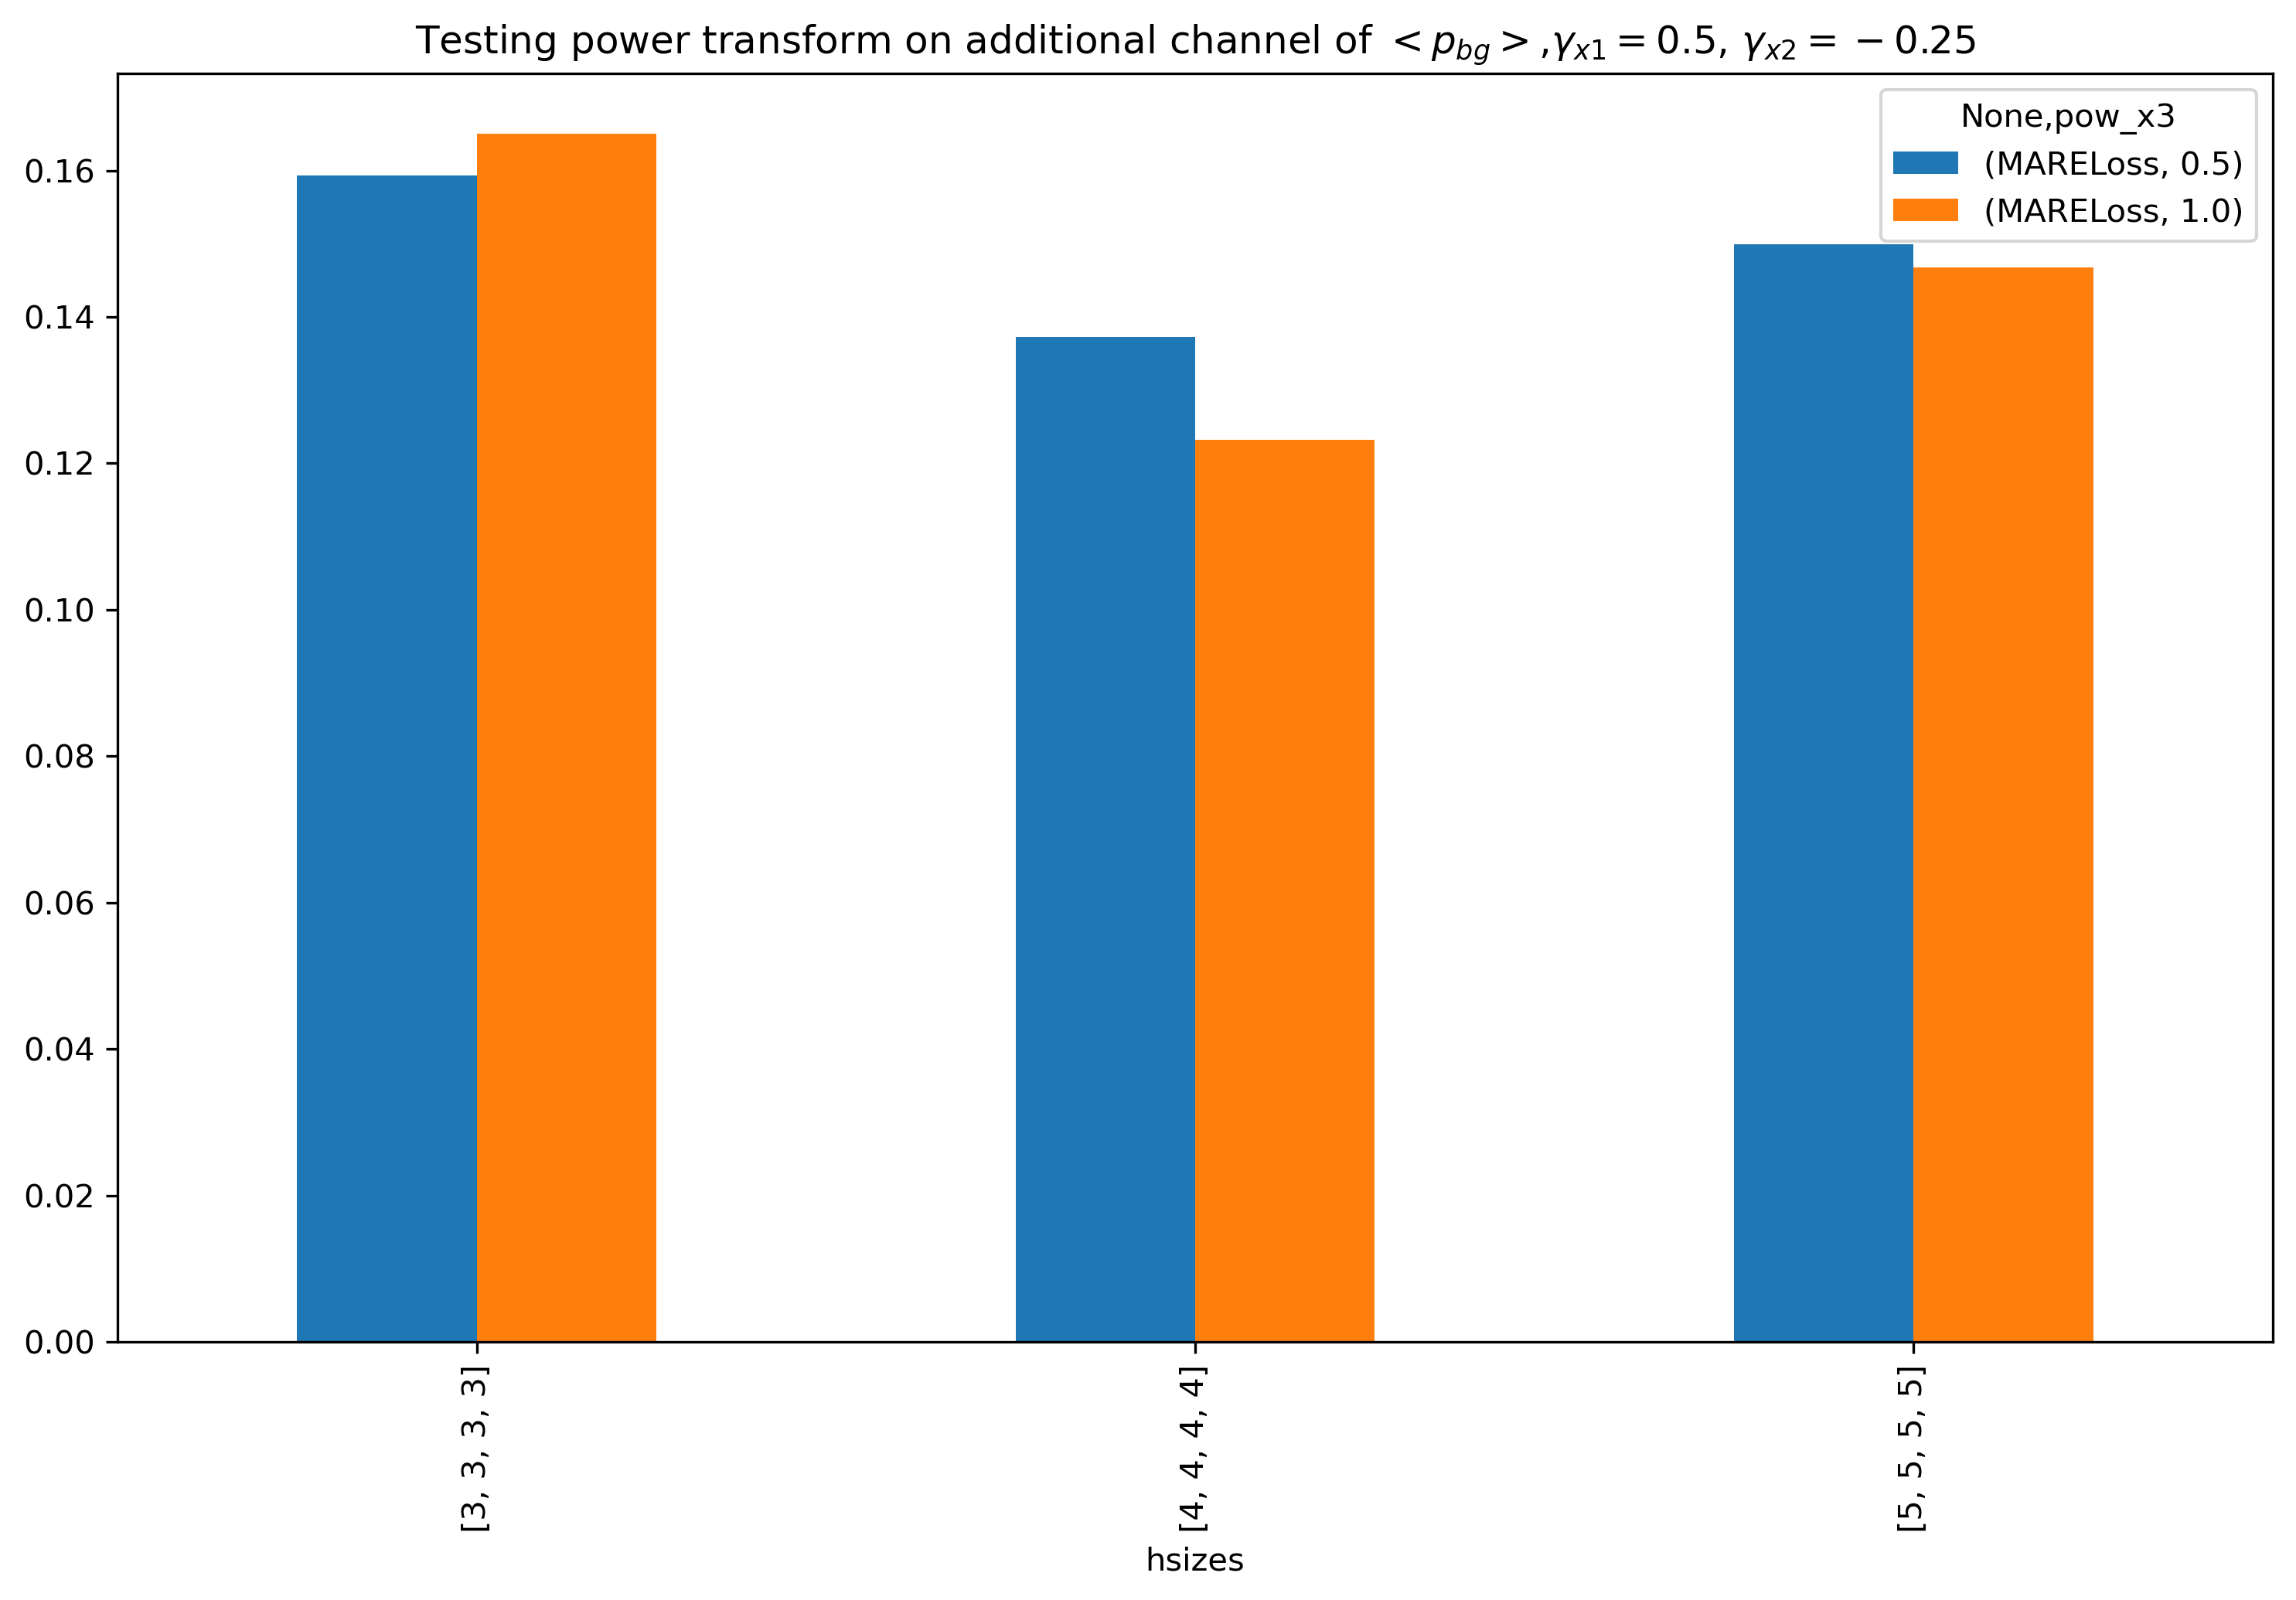

In [582]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['pow_x3'],#'fc_size'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on additional channel of $<p_{bg}>$,$\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$')
plt.tight_layout()
plt.show()

<ipython-input-587-74daf544c8d8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(bg_res[bg_res.use_bg][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],
<ipython-input-587-74daf544c8d8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(bg_res[bg_res.use_bg][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],


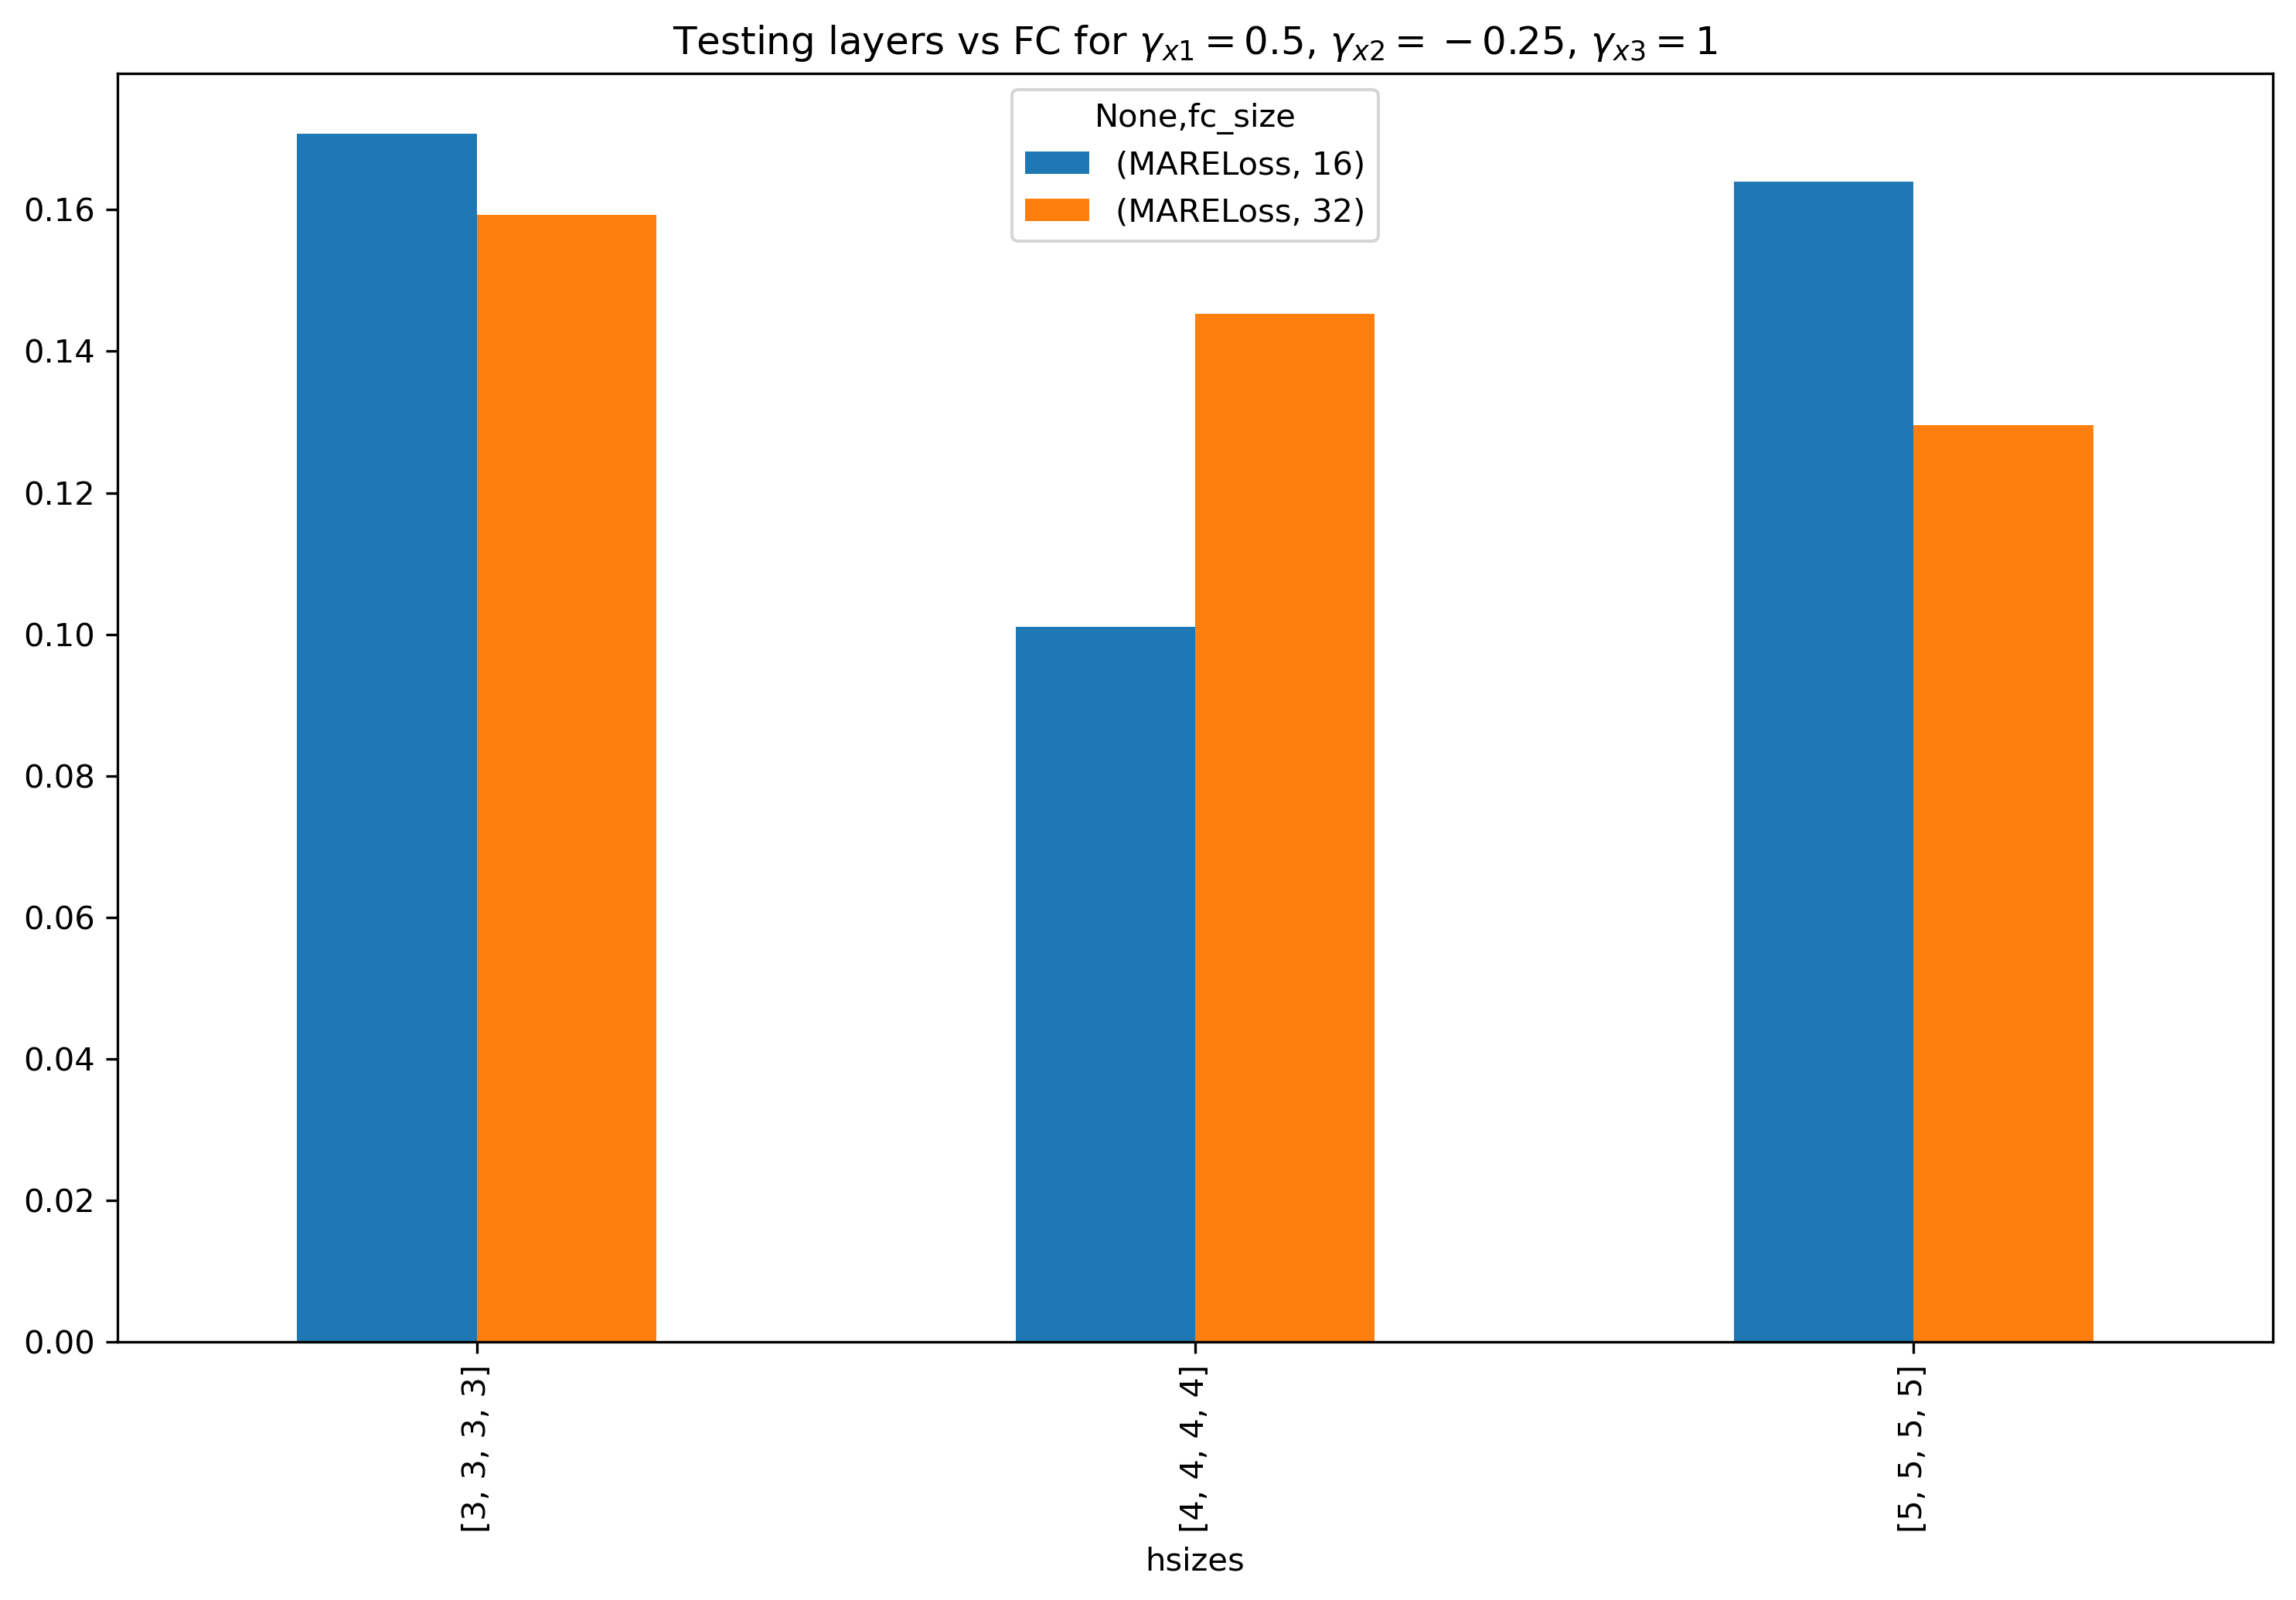

In [587]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.use_bg][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['fc_size'],
               index=['hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
plt.tight_layout()
plt.show()

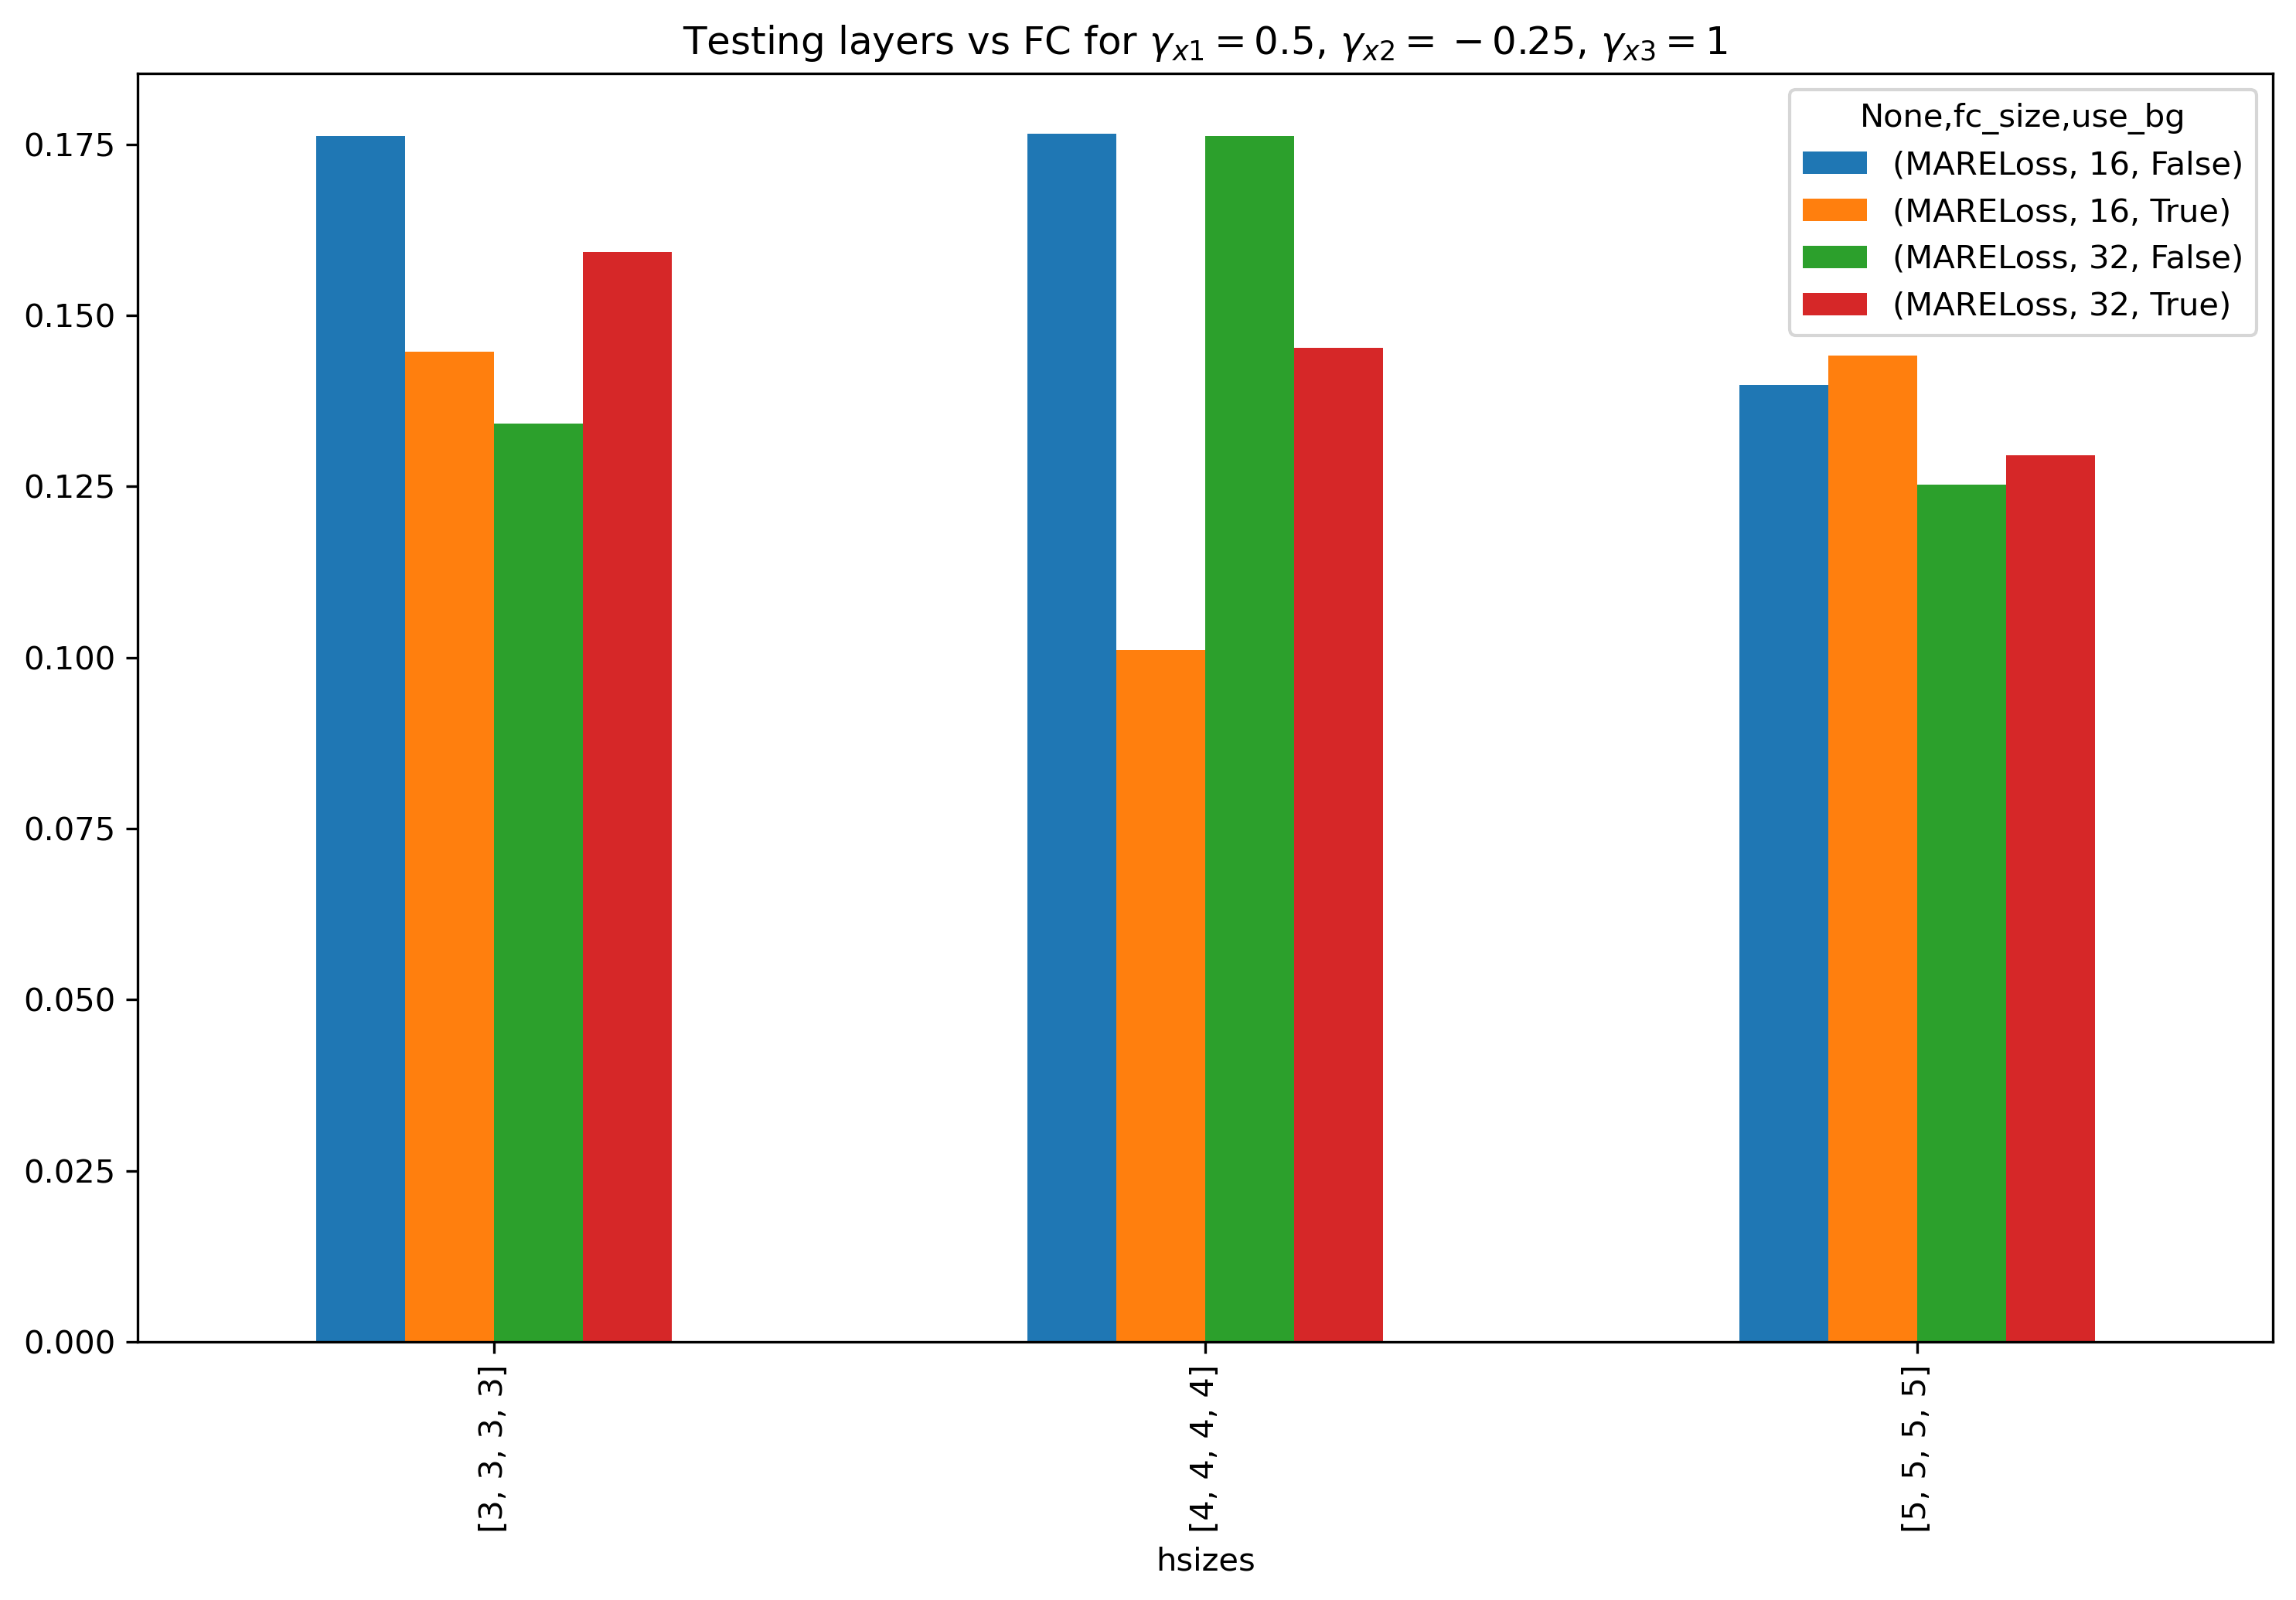

In [586]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['fc_size','use_bg'],
               index=['hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
plt.tight_layout()
plt.show()


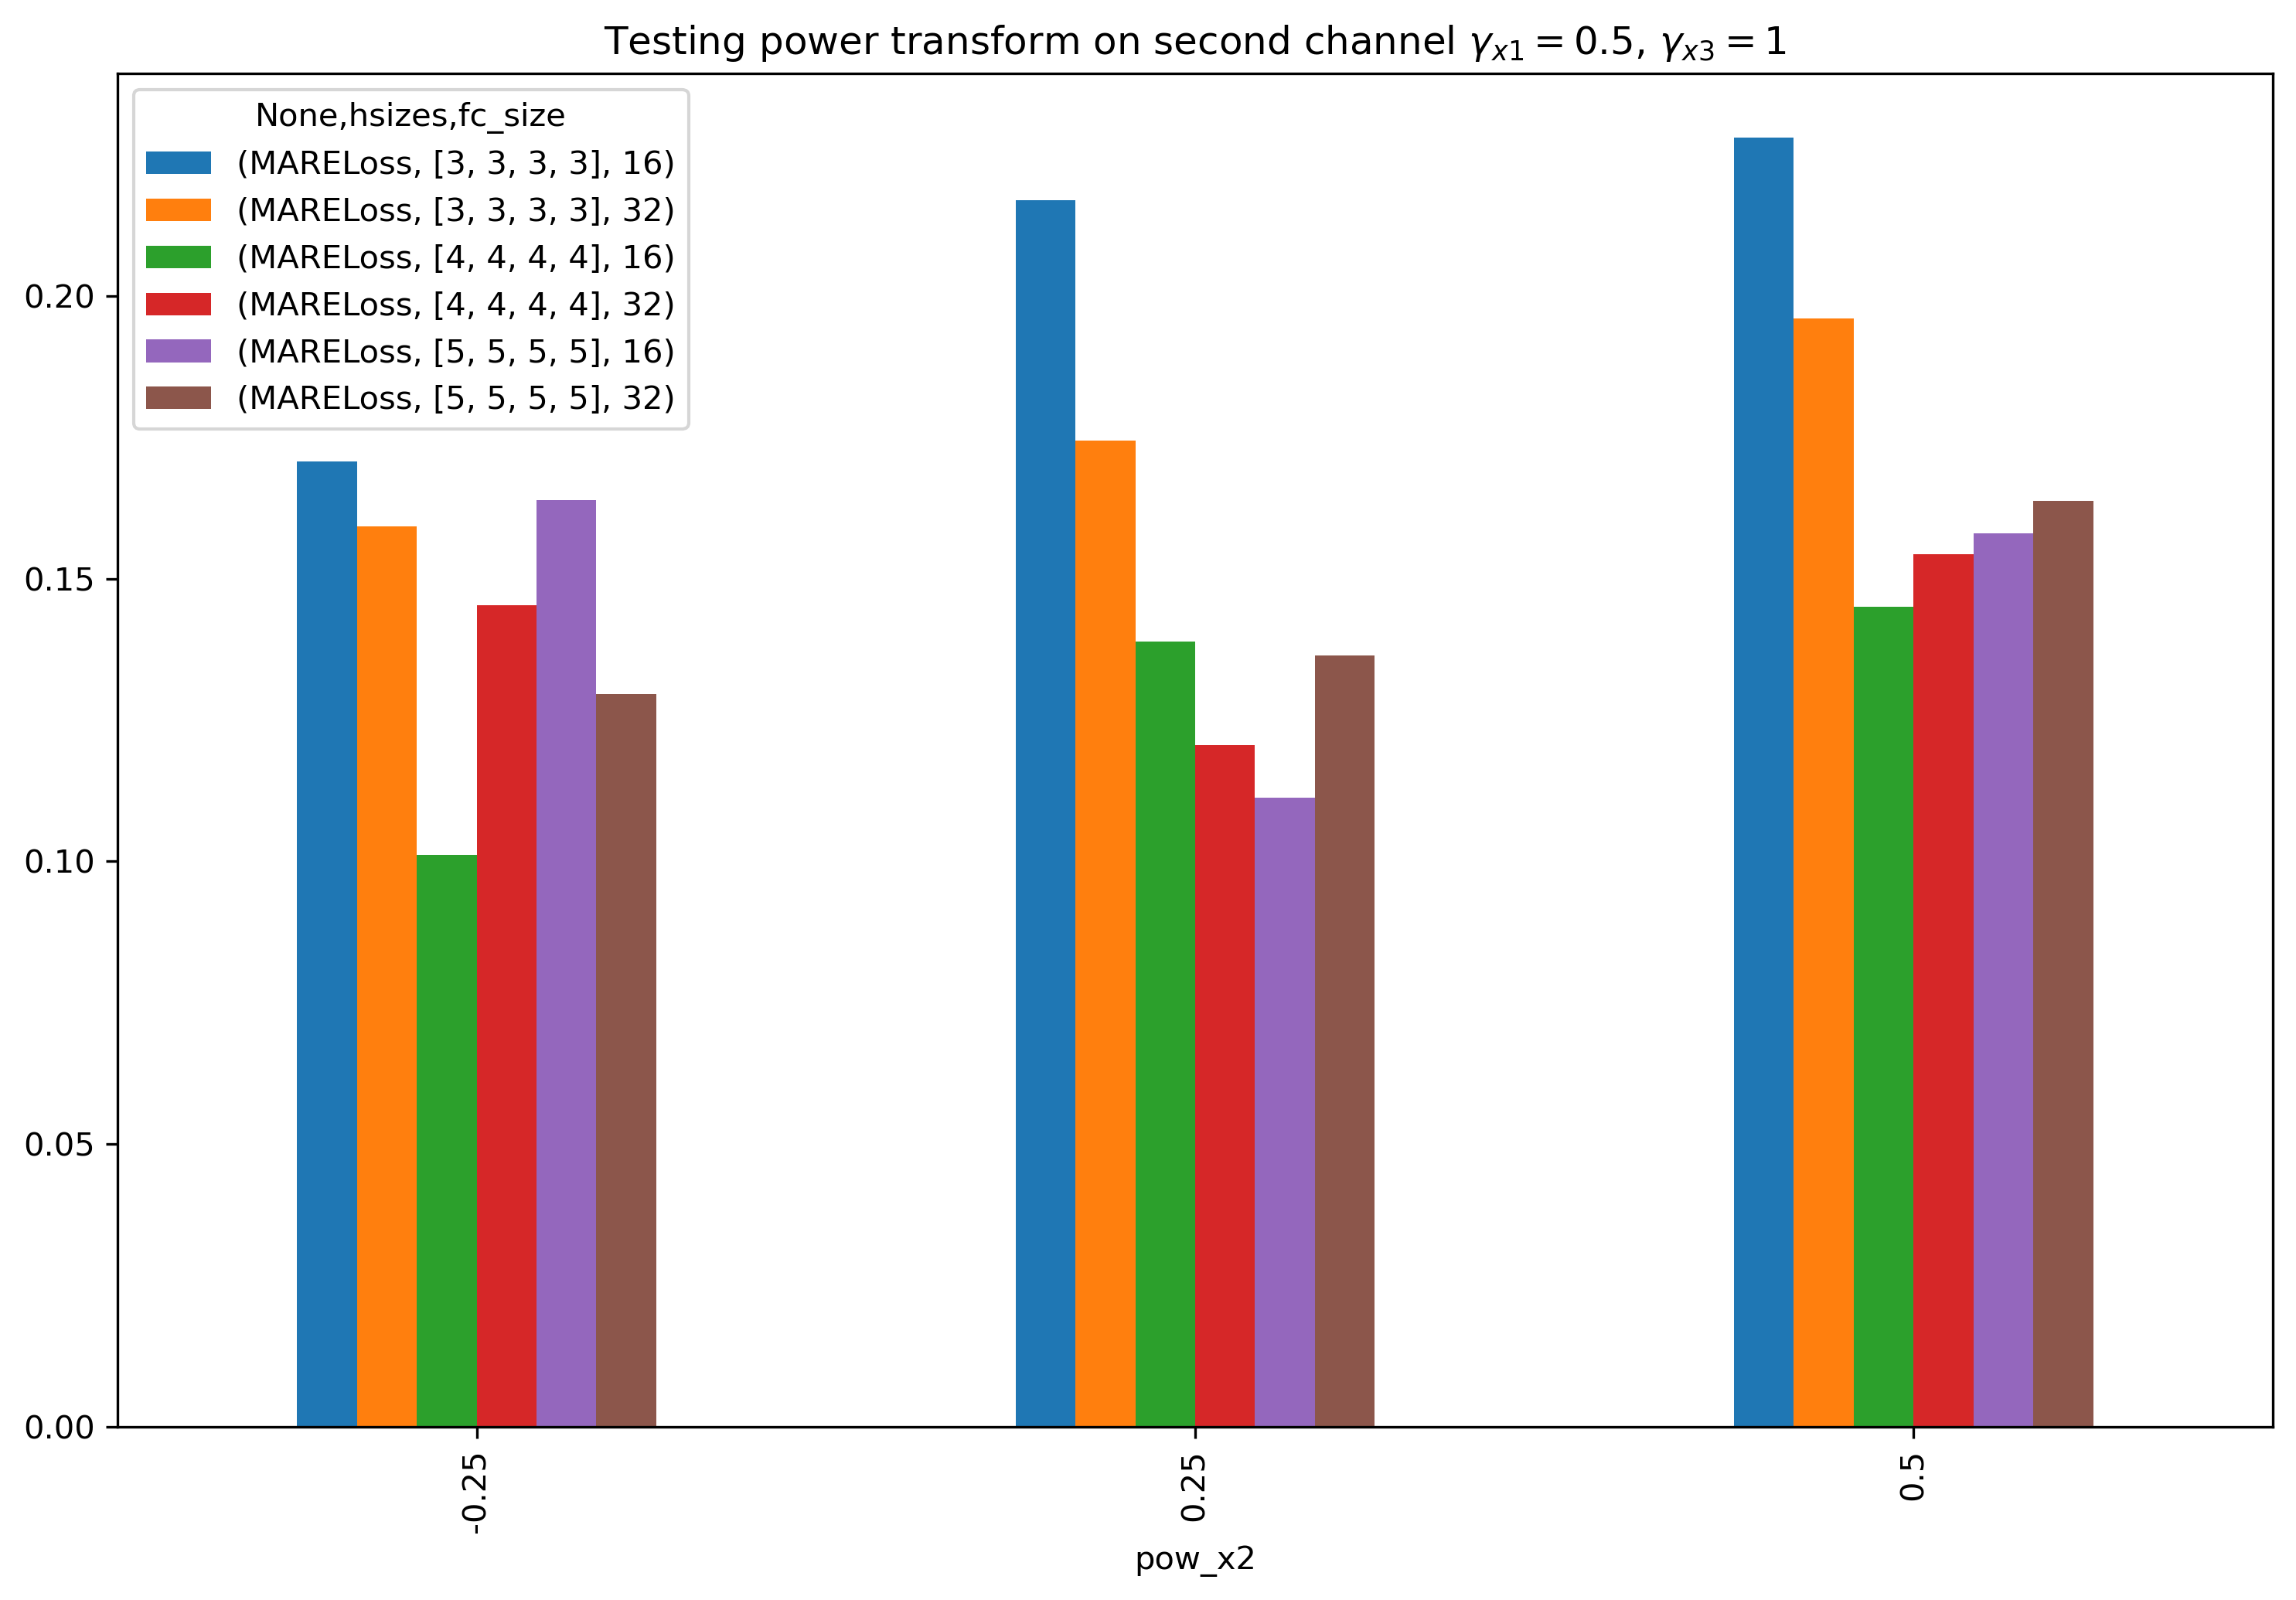

In [547]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x3==1.0],
               values=['MARELoss'],
               columns= ['hsizes','fc_size'],
               index=['pow_x2'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
plt.tight_layout()
plt.show()

In [440]:
# TODO: show figure of different power transform on bg only
# TODO: show r^2 * pbg
# TODO: onclude O(r)
# TODO : a single FC
